In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
sys.path.append(os.path.abspath("../../LHAPDF-files/"))
from tools import PDFs
from LO import F123LO
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc
from data import *
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
from scipy.optimize import minimize

In [2]:
sc.hyp2f1(2, 3, 4,-79.0032)

0.0004333404409370759

In [3]:
def getAverage(dt) : 
    arr=[]
    for k, i in dt.items(): 
        if (k!="1_0" and k!="1_1") :
            arr.append(i)

    arr= np.array(arr)
    vec= []
    Ncol= arr.shape[1]
    for i in range(Ncol) : 
        vec.append(np.average(arr[:,i]))
    return np.array(vec)


def getApproxh2of2 (x, par, order=4) : 
    su =0
    a= par[0]
    b= par[1]
    for j in range(1, order+1) : 
        #print(j, su)
        su = su + ((-1)**(j)/(math.factorial(j)*(j+1))) * ((1-x)/(x**2) ) * sc.hyp2f1(2, j+1, j+2, (x-1)/x)
    return (1-x)/x + (a+b/np.log(1+x))*su


def getApproxg2of2(x, par, order =4) : 
    su =0
    a= par[0]
    b= par[1]
    for j in range(1, order+1) : 
        #print(j, su)
        su = su + ((-1)**(j)/(math.factorial(j)*(j+2))) * ((1-x)**2/(x**2) ) * sc.hyp2f1(2, j+2, j+3, (x-1)/x)
    return -np.log(x) - (1-x) + (a+b/np.log(1+x))*su


'''
##############################################
def getApproxh2of2 (x, par=[3., 0], order=4) : 
    a= par[0]
    b= par[1]
    a= (a+b*np.log(1-x))
    ret =(1-x)* sc.hyp2f1(2, a+1, a+2, 1-x) /(a+1)
    return ret


def getApproxg2of2(x, par=[3., 0], order =4) : 
    a= par[0]
    b= par[1]
    a= (a+b*np.log(1-x))
    ret = (1-x)*((1+a*x)*sc.hyp2f1(1, a+1, a+2, 1-x) /(a+1)   -1 )
    return ret
    #########################################
'''

def getApproxh3of3 (x, par, order=4) : 
    su =0
    a= par[0]
    b= par[1]
    for j in range(1, order+1) : 
        #print(j, su)
        su = su + ((-1)**(j)/(math.factorial(j)*(j+1))) * ((1-x)/x) * sc.hyp2f1(1, j+1, j+2, (x-1)/x)
    return -np.log(x) + (a+b/np.log(1+x)) *su


def getApproxh2of1 (x, par, order=4) : 
    return 2.*x*getApproxh2of2(x, par, order)

def getApproxg2of1 (x, par, order=4) : 
    return 2.*x*getApproxg2of2(x, par, order)

def getF2TMCoF2leading_UB(x, Q) : 
    M=0.938
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    return 1.+ 6*mu*x*xi*(1-xi)/r + 12*(mu*x*xi/r)**2 *(-np.log(xi)-1+xi)

def getF3TMCoF3leading_UB(x, Q) : 
    M=0.938
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    return 1- (2*mu*x*xi/r)*np.log(xi)



def getApproxF1TMCoF1leading(x, Q, par, order=4) : 
    M=0.938
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    return 1+ mu * (x*xi/r)*getApproxh2of1(xi, par, order) + mu**2 * (2*x**2*xi/(r**2))*getApproxg2of1(xi, par, order)

def getApproxF2TMCoF2leading(x, Q, par, order=4) : 
    M=0.938
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    return 1+ 6*mu*x*xi**2*getApproxh2of2(xi, par, order)/r + 12*(mu*x*xi/r)**2*getApproxg2of2(xi, par, order)
    #return (par[0]+ par[1]/np.log(1+x) ) *getF2TMCoF2leading_UB(x, Q)


def getApproxF3TMCoF3leading(x, Q, par, order=4) : 
    M=0.938
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    return 1+ 2*mu*xi*x*getApproxh3of3(xi, par, order)/r
    #return (par[0]+ par[1]/np.log(1+x) ) *getF3TMCoF3leading_UB(x, Q)


def getF1TMCoF1leading_fred(x, Q) : 
    a= 1.28960439
    b=  1.32267095
    c= 0.2940829 /Q**2
    d=  0.97475363 
    e =  7.88686631
    return c*x**a*(1-x/d)**b+x*np.exp(-Q)/e

def getF2TMCoF2leading_fred(x, Q) : 
    a=  1.82100918 
    b= 36.9734048 
    c=  3.60580198/Q**2
    d=  12.57227038
    return c*x**a*(1-x/d)**b

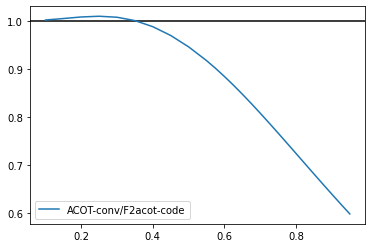

In [4]:
F2acot_conv = np.array(nCTEQ15_F2AcotConv_NC_Q_1_3['1_1'])
F2acot = np.array(nCTEQ15_F2Acot_NC_Q_1_3['1_1'])
F2m0 = np.array(nCTEQ15_F2massless_NC_Q_1_3['1_1'])


xlist= np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625,
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95])
Q=1.3
M=0.938

xilist = np.array([ 2.0*x/(1+np.sqrt(1+(2.*x*M/Q)**2)) for x in xlist])


F2fred = np.array([0.340672, 0.330037, 0.310036, 0.284095, 0.254535, 0.223873,
  0.194133, 0.166619, 0.142049, 0.120752, 0.111301, 0.102605,
  0.0946352, 0.087351, 0.0807101, 0.07465, 0.0691147, 0.0640579,
  0.0594385, 0.0552266, 0.0513841, 0.0478679, 0.0446457, 0.0416918,
  0.0389817, 0.0364944])
F2H2fred = np.array([0.00815737, 0.0151158, 0.0215194, 0.0263404,
   0.0292207, 0.0302815, 0.0298909, 0.0284847, 0.0264622, 0.0241346,
  0.0229281, 0.021721, 0.0205287, 0.0193629, 0.0182318, 0.0171414,
  0.0160961, 0.0150984, 0.0141499, 0.0132509, 0.0124007, 0.0115984,
  0.0108427, 0.0101319, 0.00946415, 0.00883752])
F2G2fred= np.array([0.0000910257,
  0.000284396, 0.000568235, 0.000884731, 0.00117438, 0.00139632,
  0.00153323, 0.00158673, 0.00156974, 0.00149972, 0.00145036,
  0.00139413, 0.00133284, 0.00126805, 0.00120115, 0.00113329,
  0.00106544, 0.000998405, 0.000932812, 0.000869155, 0.000807812,
  0.000749052, 0.000693062, 0.000639953, 0.00058978, 0.000542546])

F2acot_corr = F2acot_conv*xlist/xilist

#print(len(F2H2fred), len(F2m0), len(xlist))
#F2m0
plt.axhline(1.0, color="black")
#plt.plot(xlist, F2acot_conv/F2acot, label="ACOT-conv/F2acot-code")
plt.plot(xlist,F2acot_corr/F2acot,  label="ACOT-conv/F2acot-code")
#plt.plot(xlist, F2acot/F2acot, label="ACOT-code")
#plt.plot(xlist, F2m0 , label="Massless")
plt.legend()




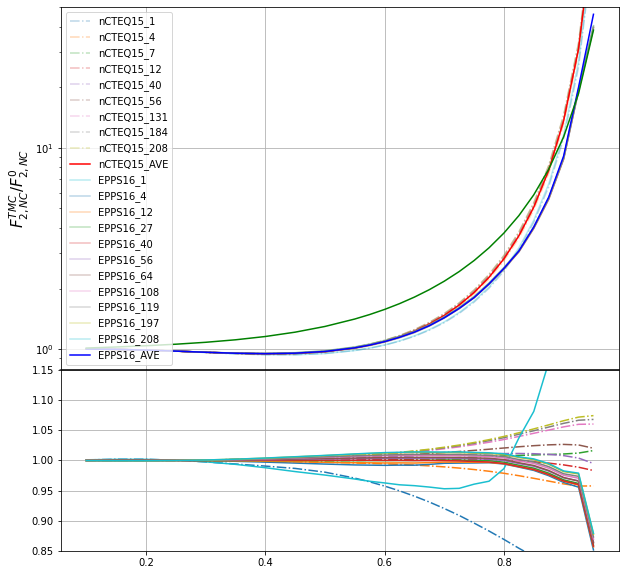

In [4]:
fig, axs = plt.subplots(2, sharex=True, sharey=False, figsize=[10,10], gridspec_kw={'height_ratios': [2, 1]})


x= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
Q=1.5

nCTEQ15_F2 = {1: [1.00244, 0.999881, 0.991639, 0.978447, 0.962687, 0.948061, 0.93887, 0.9391, 0.952418, 0.985, 1.01162, 1.04768, 1.09574, 1.15905, 1.24302, 1.35471, 1.50561, 1.71353, 2.00868, 2.44408, 3.12543, 4.26948, 6.40785, 11.1596, 25.2604, 102.28],
4: [1.0016, 0.998152, 0.990062, 0.978221, 0.96479, 0.952852, 0.946255, 0.949446, 0.968249, 1.01042, 1.0437, 1.08802, 1.14638, 1.22264, 1.32312, 1.45645, 1.63591, 1.88356, 2.23446, 2.75288, 3.56597, 4.92854, 7.47146, 13.112, 29.7262, 118.787],
7: [1.00162, 0.997892, 0.989838, 0.978227, 0.965172, 0.953635, 0.947386, 0.950998, 0.970669, 1.01454, 1.04911, 1.0951, 1.15564, 1.2348, 1.33918, 1.47788, 1.6648, 1.92336, 2.29039, 2.83403, 3.68926, 5.12566, 7.81276, 13.7894, 31.4274, 126.062],
12: [1.0015, 0.997857, 0.989724, 0.978085, 0.965111, 0.953809, 0.94798, 0.952162, 0.971497, 1.01604, 1.05044, 1.09615, 1.15625, 1.2348, 1.33825, 1.47564, 1.66062, 1.91624, 2.27867, 2.81477, 3.65672, 5.06811, 7.70229, 13.5423, 30.6984, 121.953],
40: [1.00146, 0.997645, 0.989461, 0.97798, 0.965384, 0.954571, 0.949336, 0.954133, 0.974871, 1.01959, 1.05455, 1.10093, 1.16186, 1.24148, 1.34632, 1.4856, 1.67316, 1.93255, 2.30045, 2.84504, 3.70093, 5.13607, 7.81488, 13.7525, 31.1694, 123.397],
56: [1.00144, 0.997568, 0.989394, 0.977993, 0.965525, 0.954803, 0.949604, 0.954389, 0.975262, 1.0204, 1.0557, 1.10253, 1.1641, 1.24456, 1.35059, 1.49153, 1.68145, 1.94439, 2.31767, 2.87091, 3.74168, 5.20375, 7.93701, 14.0064, 31.8444, 126.542],
131: [1.00147, 0.997465, 0.989233, 0.97792, 0.965637, 0.955137, 0.950052, 0.954924, 0.976079, 1.02189, 1.05772, 1.10527, 1.16778, 1.24954, 1.35733, 1.50078, 1.69428, 1.96258, 2.34407, 2.91059, 3.80432, 5.3082, 8.12661, 14.4035, 32.9081, 131.52], 
184: [1.00152, 0.997439, 0.989152, 0.977822, 0.965601, 0.955186, 0.950196, 0.95515, 0.976436, 1.02245, 1.05842, 1.10614, 1.16888, 1.25092, 1.35909, 1.50293, 1.69733, 1.96674, 2.34991, 2.91913, 3.81749, 5.32977, 8.1652, 14.4832, 33.118, 132.474],
208: [1.00155, 0.997446, 0.989117, 0.977786, 0.965593, 0.955206, 0.950244, 0.955221, 0.976553, 1.02267, 1.05873, 1.10655, 1.16943, 1.25167, 1.36011, 1.50446, 1.69923, 1.96943, 2.3538, 2.92497, 3.82668, 5.34519, 8.19336, 14.5427, 33.2799, 133.255,],
}
A=list(nCTEQ15_F2.keys())

for a in A : 
    axs[0].plot(x, nCTEQ15_F2 [a], label="nCTEQ15_"+str(a), alpha=0.3, linestyle="dashdot")

axs[0].plot(x, getAverage(nCTEQ15_F2), label="nCTEQ15_AVE",color="red",linestyle="-" )

#ratio = [1.-4.*0.938**2*myx**2/(Q**2) for myx in x]
#plt.plot(x, ratio, label="Theory", color="black")



EPPS_F2 = {1: [1.00237, 0.999718, 0.991625, 0.97867, 0.963252, 0.948691, 0.938772, 0.93771, 0.950619, 0.984327, 1.01206, 1.04953, 1.09906, 1.16448, 1.25081, 1.36566, 1.52058, 1.73417, 2.03748, 2.48629, 3.18857, 4.37589, 6.61782, 11.6383, 26.6518, 108.267],
4: [1.00147, 0.998235, 0.99031, 0.978491, 0.96511, 0.953523, 0.947606, 0.951183, 0.968389, 1.00807, 1.0401, 1.08136, 1.13643, 1.2058, 1.3001, 1.42625, 1.58737, 1.79773, 2.10228, 2.50566, 3.03995, 3.97959, 5.54765, 8.77876, 19.1347, 39.2525],
12: [1.00139, 0.99805, 0.990107, 0.978377, 0.965225, 0.954296, 0.948983, 0.953414, 0.971308, 1.01173, 1.0441, 1.08564, 1.1407, 1.21015, 1.3039, 1.42915, 1.58991, 1.79967, 2.10339, 2.50667, 3.042, 3.98437, 5.55685, 8.79723, 19.2072, 39.4849],
27: [1.00131, 0.998267, 0.989917, 0.978326, 0.965355, 0.954973, 0.95027, 0.955399, 0.974092, 1.01531, 1.04797, 1.08989, 1.14526, 1.21522, 1.309, 1.43415, 1.59532, 1.80516, 2.1091, 2.51325, 3.04955, 3.99469, 5.5713, 8.81773, 19.2578, 39.6165],
40: [1.00131, 0.997906, 0.989711, 0.978177, 0.965567, 0.95504, 0.950544, 0.955844, 0.974679, 1.01596, 1.04855, 1.09038, 1.14553, 1.21523, 1.30846, 1.43276, 1.59313, 1.80213, 2.10477, 2.50746, 3.04267, 3.98548, 5.55875, 8.80073, 19.2243, 39.544], 
56: [1.00124, 0.997753, 0.989758, 0.978141, 0.965716, 0.955542, 0.951403, 0.957169, 0.976652, 1.01873, 1.05173, 1.09399, 1.14951, 1.21979, 1.3135, 1.43852, 1.60014, 1.81025, 2.11466, 2.52009, 3.05818, 4.00776, 5.59108, 8.84864, 19.3448, 39.859], 
64: [1.00121, 0.997694, 0.989701, 0.978159, 0.965737, 0.955691, 0.951765, 0.957642, 0.977335, 1.01968, 1.05283, 1.09529, 1.15101, 1.22155, 1.31539, 1.44051, 1.60245, 1.81293, 2.11796, 2.52411, 3.0624, 4.01278, 5.59689, 8.85325, 19.336, 39.8023],
108: [1.00114, 0.997617, 0.989477, 0.97808, 0.966003, 0.956167, 0.952592, 0.959103, 0.979345, 1.02232, 1.05579, 1.0986, 1.15458, 1.22554, 1.31954, 1.44481, 1.60736, 1.81816, 2.12379, 2.53134, 3.07162, 4.02657, 5.61783, 8.88666, 19.4338, 40.082], 
119: [1.00113, 0.997566, 0.989559, 0.978073, 0.965976, 0.956315, 0.953005, 0.959526, 0.980074, 1.02341, 1.05702, 1.10003, 1.15624, 1.22752, 1.32177, 1.44732, 1.61039, 1.82165, 2.12807, 2.53688, 3.07856, 4.03692, 5.63321, 8.91, 19.495, 40.2463],
197: [1.00109, 0.997464, 0.989333, 0.978023, 0.966215, 0.956785, 0.953825, 0.96099, 0.982096, 1.02615, 1.06019, 1.10359, 1.16, 1.23163, 1.32599, 1.45167, 1.61547, 1.82736, 2.1348, 2.54536, 3.08899, 4.0521, 5.65537, 8.94246, 19.5751, 40.4542],
208: [1.00107, 0.997434, 0.989371, 0.978032, 0.966183, 0.956882, 0.954027, 0.961227, 0.982401, 1.02664, 1.06086, 1.10439, 1.16086, 1.23258, 1.32706, 1.45297, 1.61711, 1.82926, 2.13708, 2.54823, 3.09242, 4.0569, 5.66222, 8.9526, 19.6014, 40.524],
}

A=list(EPPS_F2.keys())
for a in A : 
    axs[0].plot(x, EPPS_F2[a], label="EPPS16_"+str(a),alpha=0.3, linestyle="-",)

axs[0].plot(x, getAverage(EPPS_F2), label="EPPS16_AVE", color="blue", linestyle="-" )


axs[0].set_ylim(0.8, 50)
axs[0].set_yscale("log")
axs[0].grid("both")
axs[0].legend()
axs[0].set_xlabel("x", fontsize=20)
axs[0].set_ylabel(r"$F_{2, NC}^{TMC}/F_{2, NC}^{0}$", fontsize=15)

axs[0].plot(x, [getApproxF2TMCoF2massless(myx, 1.5, 3) for myx in x], color="green")

#####################################
ave_ncteq = getAverage(nCTEQ15_F2)
ave_epps = getAverage(EPPS_F2)

A=list(nCTEQ15_F2.keys())
for a in A : 
    axs[1].plot(x, nCTEQ15_F2[a]/ave_ncteq,  alpha=0.99, linestyle="dashdot")

A=list(EPPS_F2.keys())
for a in A : 
    axs[1].plot(x, EPPS_F2[a]/ave_epps,alpha=0.99, linestyle="-",)

axs[1].set_ylim(0.85, 1.15)
axs[1].grid("both")

plt.subplots_adjust(hspace=0.005, wspace = 0.00)






No handles with labels found to put in legend.


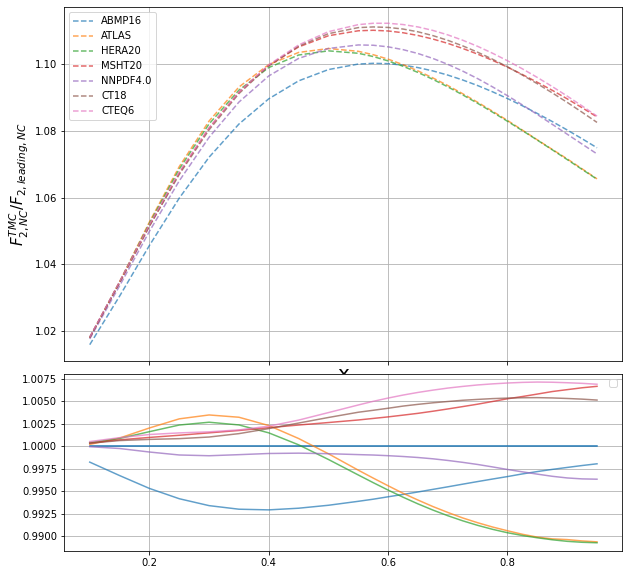

In [3]:
fig, axs = plt.subplots(2, sharex=True, sharey=False, figsize=[10,10], gridspec_kw={'height_ratios': [2, 1]})


x= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
Q=1.5

ABMP16 = {1: [1.01593, 1.03048, 1.04569, 1.05989, 1.07216, 1.0821, 1.08967, 1.09505, 1.09844, 1.10009, 1.10031, 1.10021, 1.09976, 1.09903, 1.09803, 1.09678, 1.09531, 1.09364, 1.09177, 1.08974, 1.08758, 1.08527, 1.08285, 1.08032, 1.07769, 1.07498]}
ATLAS = {1: [1.01793, 1.03478, 1.05273, 1.06933, 1.08301, 1.09321, 1.09993, 1.10357, 1.10475, 1.10391, 1.1029, 1.10156, 1.0999, 1.09804, 1.09593, 1.09365, 1.09119, 1.08863, 1.08594, 1.08317, 1.08028, 1.07736, 1.07449, 1.07166, 1.06866, 1.06566]}
HERA20 = {1: [1.01813, 1.03473, 1.0523, 1.0686, 1.08214, 1.09228, 1.09904, 1.1028, 1.10405, 1.10332, 1.10234, 1.10103, 1.09942, 1.09757, 1.0955, 1.09325, 1.09084, 1.08831, 1.08566, 1.08293, 1.08013, 1.07728, 1.07438, 1.07145, 1.0685, 1.06555]}
MSHT20 = {1: [1.01808, 1.03457, 1.05163, 1.06739, 1.08087, 1.09161, 1.09967, 1.10522, 1.10858, 1.11007, 1.11022, 1.11001, 1.10948, 1.10866, 1.10759, 1.10629, 1.10477, 1.10306, 1.10119, 1.09917, 1.09694, 1.09462, 1.09222, 1.08966, 1.087, 1.08423]}
NNPDF40 = {1: [1.01767, 1.03358, 1.04993, 1.06506, 1.07813, 1.08869, 1.09653, 1.10178, 1.10476, 1.10582, 1.10573, 1.10525, 1.10441, 1.10325, 1.10177, 1.1, 1.09797, 1.09572, 1.09324, 1.0906, 1.08783, 1.08496, 1.08202, 1.07906, 1.07609, 1.07314]}
CT18 = {1: [1.01806, 1.03449, 1.0514, 1.06699, 1.08037, 1.09123, 1.09956, 1.10546, 1.1092, 1.11102, 1.11122, 1.11107, 1.11059, 1.10976, 1.10862, 1.1072, 1.10554, 1.10364, 1.10154, 1.09925, 1.09679, 1.09419, 1.09145, 1.0886, 1.08564, 1.08259]}
CTEQ6M = {1: [1.01825, 1.03482, 1.05197, 1.06767, 1.08099, 1.09168, 1.09985, 1.10582, 1.1098, 1.11191, 1.11232, 1.11232, 1.11194, 1.11122, 1.11017, 1.10884, 1.10723, 1.1054, 1.10333, 1.10108, 1.09865, 1.09607, 1.09334, 1.09049, 1.08753, 1.08448]}
DUMMY= {1: [1.01768, 1.03322, 1.04913, 1.06377, 1.07642, 1.08681, 1.095, 1.10126, 1.10577, 1.10859, 1.10938, 1.10978, 1.10979, 1.10946, 1.1088, 1.10783, 1.10658, 1.10507, 1.10331, 1.10134, 1.09917, 1.09681, 1.0943, 1.09164, 1.08884, 1.08593],}

l = [ABMP16, ATLAS, HERA20, MSHT20, NNPDF40, CT18, CTEQ6M, DUMMY]
lpdfs =[[ABMP16, "ABMP16"], [ATLAS, "ATLAS"], [HERA20, "HERA20"], [MSHT20, "MSHT20"], [NNPDF40, "NNPDF4.0"], [CT18, "CT18"], [CTEQ6M, "CTEQ6"]]

def average(mt) : 
    ta = []
    for myp in mt : 
        ta.append(myp[1])
    ta= np.array(ta)
    col = ta.shape[1]
    av = []
    for i in range(col) : 
        av.append(np.average(ta[:, i]))

    return np.array(av)

for i, a in zip(range(len(lpdfs)), lpdfs) : 
    axs[0].plot(x, a[0][1], label=a[1], alpha=0.7, linestyle="dashed", color="C"+str(i))


#axs[0].plot(x, [getApproxF2TMCoF2leading(myx, 1.5, 2.09, 20) for myx in x], label="Approximaton", color="red")
#axs[0].set_ylim(1., 1.2)
#axs[0].set_yscale("log")
axs[0].grid("both")
axs[0].legend()
axs[0].set_xlabel("x", fontsize=20)
axs[0].set_ylabel(r"$F_{2, NC}^{TMC}/F_{2, leading, NC}$", fontsize=15)

#####################################
ave = average(l)
plt.plot(x, ave/ave)

for i, a in zip(range(len(lpdfs)), lpdfs) :
    axs[1].plot(x, a[0][1]/ave, alpha=0.7, linestyle="-", color="C"+str(i))

#axs[1].plot(x, np.array([getApproxF2TMCoF2leading(myx, 1.5, 2.11, 4) for myx in x])/ave, label="Approximaton", color="red")

#axs[1].set_ylim(0.989, 1.01)
axs[1].grid("both")
axs[1].legend()
plt.subplots_adjust(hspace=0.05, wspace = 0.01)






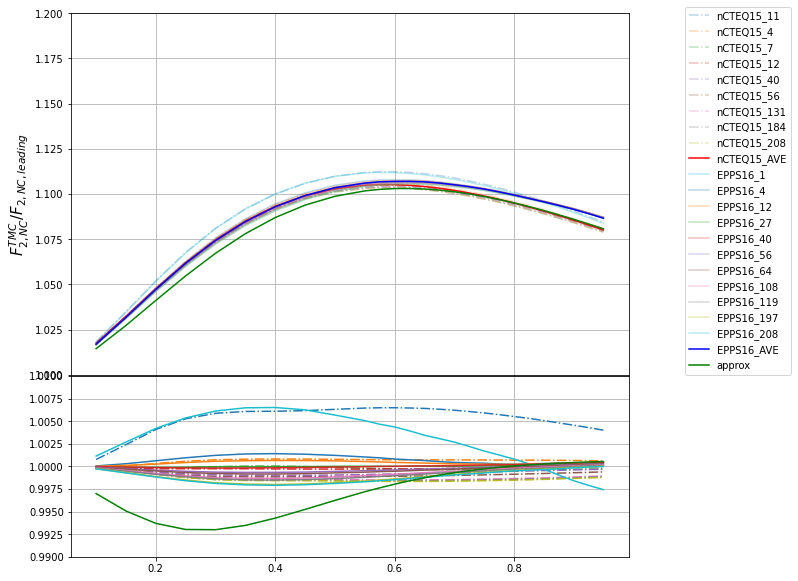

In [90]:
fig, axs = plt.subplots(2, sharex=True, sharey=False, figsize=[10,10], gridspec_kw={'height_ratios': [2, 1]})


xlist= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
Q=1.5

nCTEQ15_F2 = {1: [1.01824, 1.03482, 1.05196, 1.06767, 1.08099, 1.09168, 1.09985, 1.10582, 1.1098, 1.11191, 1.11232, 1.11232, 1.11193, 1.11122, 1.11017, 1.10884, 1.10723, 1.1054, 1.10333, 1.10108, 1.09866, 1.09607, 1.09334, 1.09049, 1.08753, 1.08448],
4: [1.01731, 1.03238, 1.04802, 1.06268, 1.07546, 1.08595, 1.09407, 1.09993, 1.1037, 1.10562, 1.10597, 1.10596, 1.1056, 1.10494, 1.10398, 1.10278, 1.10133, 1.09968, 1.09782, 1.09579, 1.09361, 1.09128, 1.08883, 1.08625, 1.08357, 1.08082],
7: [1.01722, 1.03206, 1.04746, 1.06194, 1.07464, 1.08511, 1.09321, 1.09902, 1.10272, 1.10456, 1.10488, 1.10484, 1.10445, 1.10377, 1.1028, 1.10158, 1.10013, 1.09848, 1.09663, 1.09462, 1.09246, 1.09015, 1.08773, 1.08519, 1.08255, 1.07984],
12: [1.01727, 1.03208, 1.04741, 1.0618, 1.0744, 1.0848, 1.09287, 1.09872, 1.10251, 1.10445, 1.10483, 1.10483, 1.10449, 1.10385, 1.10292, 1.10174, 1.10032, 1.09869, 1.09686, 1.09487, 1.09272, 1.09043, 1.08802, 1.08548, 1.08284, 1.08013],
40: [1.01731, 1.03192, 1.04701, 1.0612, 1.07367, 1.08401, 1.09209, 1.09796, 1.10179, 1.10379, 1.10419, 1.10422, 1.1039, 1.10328, 1.10237, 1.10121, 1.09981, 1.09821, 1.0964, 1.09443, 1.0923, 1.09003, 1.08763, 1.08512, 1.0825, 1.07981],
56: [1.01732, 1.03186, 1.04688, 1.06103, 1.07348, 1.08383, 1.09191, 1.09778, 1.10159, 1.10354, 1.10393, 1.10394, 1.1036, 1.10297, 1.10206, 1.10088, 1.09948, 1.09787, 1.09606, 1.09408, 1.09195, 1.08968, 1.08729, 1.08478, 1.08217, 1.07949],
131: [1.01741, 1.03189, 1.04676, 1.06079, 1.07319, 1.08352, 1.0916, 1.09746, 1.10123, 1.10314, 1.1035, 1.10349, 1.10314, 1.10249, 1.10156, 1.10038, 1.09896, 1.09735, 1.09553, 1.09355, 1.09142, 1.08915, 1.08677, 1.08427, 1.08167, 1.079],
184: [1.01749, 1.03197, 1.04679, 1.06077, 1.07312, 1.08343, 1.0915, 1.09735, 1.10111, 1.10302, 1.10338, 1.10337, 1.10302, 1.10237, 1.10144, 1.10026, 1.09884, 1.09723, 1.09542, 1.09344, 1.09131, 1.08904, 1.08666, 1.08416, 1.08157, 1.0789],
208: [1.01752, 1.03201, 1.04681, 1.06076, 1.07309, 1.08339, 1.09145, 1.0973, 1.10106, 1.10296, 1.10332, 1.10331, 1.10295, 1.1023, 1.10137, 1.10019, 1.09877, 1.09715, 1.09534, 1.09336, 1.09123, 1.08897, 1.08659, 1.08409, 1.08149, 1.07883],
}
A=list(nCTEQ15_F2.keys())

for a in A : 
    axs[0].plot(xlist, nCTEQ15_F2 [a], label="nCTEQ15_"+str(a), alpha=0.3, linestyle="dashdot")

axs[0].plot(xlist, getAverage(nCTEQ15_F2), label="nCTEQ15_AVE",linestyle="-" , color="red")

#ratio = [1.-4.*0.938**2*myx**2/(Q**2) for myx in x]
#plt.plot(x, ratio, label="Theory", color="black")



EPPS_F2 = {1: [1.018, 1.03451, 1.05159, 1.06733, 1.08081, 1.09171, 1.10005, 1.10599, 1.10975, 1.1116, 1.11189, 1.11177, 1.11132, 1.11054, 1.10945, 1.10808, 1.10646, 1.10461, 1.10255, 1.1003, 1.09788, 1.09531, 1.0926, 1.08977, 1.08683, 1.08379],
4: [1.01689, 1.03204, 1.04784, 1.06265, 1.07554, 1.08617, 1.09447, 1.10059, 1.10483, 1.10715, 1.10777, 1.10784, 1.10777, 1.10744, 1.10663, 1.10559, 1.10445, 1.10312, 1.10145, 1.09967, 1.09785, 1.09599, 1.09404, 1.09192, 1.08957, 1.08708],
12: [1.01685, 1.03186, 1.04745, 1.06209, 1.07484, 1.08536, 1.09365, 1.09982, 1.10416, 1.10659, 1.10727, 1.10742, 1.10741, 1.10713, 1.1064, 1.10541, 1.10431, 1.10301, 1.1014, 1.09965, 1.09783, 1.09596, 1.09401, 1.09189, 1.08954, 1.08705],
27: [1.01679, 1.03163, 1.04708, 1.06153, 1.07419, 1.08462, 1.09289, 1.09909, 1.10349, 1.10601, 1.10674, 1.10694, 1.10698, 1.10675, 1.10607, 1.10513, 1.10407, 1.1028, 1.10123, 1.09952, 1.09771, 1.09585, 1.0939, 1.09181, 1.08947, 1.08699],
40: [1.01681, 1.03166, 1.04705, 1.06146, 1.07403, 1.08449, 1.09276, 1.09897, 1.1034, 1.10596, 1.10672, 1.10694, 1.107, 1.10678, 1.10612, 1.1052, 1.10415, 1.1029, 1.10134, 1.09962, 1.09781, 1.09594, 1.09399, 1.09189, 1.08954, 1.08705],
56: [1.01674, 1.03148, 1.04675, 1.06106, 1.07355, 1.08396, 1.09221, 1.09842, 1.10287, 1.10547, 1.10625, 1.1065, 1.10658, 1.1064, 1.10577, 1.10487, 1.10384, 1.10261, 1.10108, 1.09938, 1.09759, 1.09573, 1.09379, 1.09171, 1.08938, 1.0869],
64: [1.01671, 1.03141, 1.04666, 1.06091, 1.07339, 1.08377, 1.09201, 1.09823, 1.10269, 1.10529, 1.10608, 1.10634, 1.10643, 1.10626, 1.10564, 1.10476, 1.10374, 1.10252, 1.101, 1.09932, 1.09752, 1.09566, 1.09373, 1.09166, 1.08934, 1.08686],
108: [1.01666, 1.03126, 1.04638, 1.06053, 1.0729, 1.08326, 1.09148, 1.0977, 1.1022, 1.10486, 1.10568, 1.10597, 1.10609, 1.10595, 1.10537, 1.10451, 1.10352, 1.10232, 1.10083, 1.09917, 1.09739, 1.09554, 1.09362, 1.09156, 1.08925, 1.08677],
119: [1.01663, 1.03118, 1.04627, 1.06041, 1.07275, 1.08306, 1.09127, 1.0975, 1.10199, 1.10466, 1.10549, 1.10579, 1.10592, 1.10578, 1.10522, 1.10437, 1.10338, 1.10219, 1.10072, 1.09907, 1.09729, 1.09544, 1.09353, 1.09149, 1.08918, 1.0867],
197: [1.01658, 1.03104, 1.046, 1.06004, 1.07228, 1.08256, 1.09074, 1.09697, 1.10149, 1.10421, 1.10506, 1.1054, 1.10556, 1.10546, 1.10494, 1.10412, 1.10316, 1.10199, 1.10055, 1.09891, 1.09715, 1.0953, 1.0934, 1.09137, 1.08907, 1.0866],
208: [1.01656, 1.03099, 1.04596, 1.05995, 1.07221, 1.08246, 1.09064, 1.09688, 1.1014, 1.10411, 1.10497, 1.10531, 1.10547, 1.10538, 1.10486, 1.10406, 1.10309, 1.10192, 1.10049, 1.09886, 1.09709, 1.09525, 1.09335, 1.09133, 1.08904, 1.08657],
}

A=list(EPPS_F2.keys())
for a in A : 
    axs[0].plot(xlist, EPPS_F2[a], label="EPPS16_"+str(a),alpha=0.3, linestyle="-",)

axs[0].plot(xlist, getAverage(EPPS_F2), label="EPPS16_AVE",linestyle="-", color="blue" )



Q=1.5
M=0.938
myx= [0.01*i for i in range(10, 100)]

y=[]
for x in xlist : 
    mu =(M/Q)**2
    r=np.sqrt(1+(2.*x*M/Q)**2)
    xi = 2*x/(1+r)
    a= (1.-xi)**2*6.*mu*x*xi/r#(1.-xi)*6.*mu*x*xi/r + (-np.log(xi)-1.+xi)*12.*(mu*x*xi/r)**2
    y.append(1.+a)
axs[0].plot(xlist, [getApproxF2TMCoF2leading(x, 1.5, 2.3) for x in xlist], label="approx", color="green")


axs[0].set_ylim(1., 1.2)
#axs[0].set_yscale("log")
axs[0].grid("both")
axs[0].legend(loc=[1.1,0])
axs[0].set_xlabel("x", fontsize=20)
axs[0].set_ylabel(r"$F_{2, NC}^{TMC}/F_{2, NC, leading}$", fontsize=15)

#####################################
ave_ncteq = getAverage(nCTEQ15_F2)
ave_epps = getAverage(EPPS_F2)

A=list(nCTEQ15_F2.keys())
for a in A : 
    axs[1].plot(xlist, nCTEQ15_F2[a]/ave_ncteq,  alpha=0.99, linestyle="dashdot")

A=list(EPPS_F2.keys())
for a in A : 
    axs[1].plot(xlist, EPPS_F2[a]/ave_epps,alpha=0.99, linestyle="-",)

axs[1].plot(xlist, np.array([getApproxF2TMCoF2leading(x, 1.5, 2.3) for x in xlist])/ave_ncteq, label="approx", color="green")

axs[1].set_ylim(0.99, 1.01)
axs[1].grid("both")

plt.subplots_adjust(hspace=0.005, wspace = 0.00)

[ 2.25757731 -0.07382331] 0.0002117359909165012 156


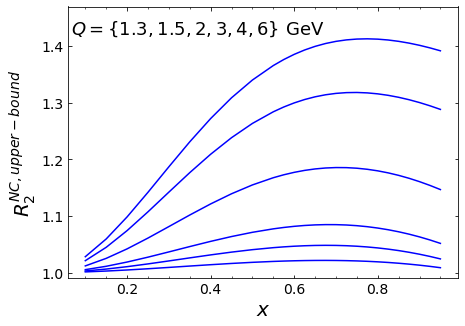

In [8]:
group= [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3, nCTEQ15_RF2_NC_Q_4, nCTEQ15_RF2_NC_Q_6, ]
#group= [nCTEQ15_RF3_NC_Q_1_3, nCTEQ15_RF3_NC_Q_1_5, nCTEQ15_RF3_NC_Q_2, nCTEQ15_RF3_NC_Q_3, nCTEQ15_RF3_NC_Q_4, nCTEQ15_RF3_NC_Q_6, ]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]

xlist= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


def model (po, a, b) :
    x= po[0]
    Q=po[1]
    par= [a, b]
    return getApproxF2TMCoF2leading(x, Q, par, 6)

xdata=[]
ydata =[]
for i, Q in zip(range(len(Q2l)), Q2l) : 
    for j, bj in zip(range(len(xlist)), xlist) :
        ydata.append(getAverage(group[i])[j])
        xdata.append([bj, Q])


   
xdata = np.array(xdata)
ydata = np.array(ydata)

def chi2 (p) : 
    a= p[0]
    b = p[1]
    theo = np.array([model(x, a, b) for x in xdata])
    ret = np.sum((ydata-theo)**2)
    #print(p, ret)
    return ret

res = minimize(chi2, [3.09, 0.0], method="Nelder-Mead")
res = minimize(chi2, res.x, method="BFGS")
p= res.x

print(res.x, res.fun, len(ydata))


#plt.figure(figsize=[7,5])
fig, ax = plt.subplots( figsize=[7,5])
for i, g in zip(range(len(group)), group) : 
    #ap = np.array([getApproxF2TMCoF2leading(x, Q2l[i], 2.11, 4) for x in xlist])
    A = list(g.keys())
    #for j, a in zip(range(len(A)), A) : 
    #        if (a=='1_1') : 
    #            ax.plot(xlist, np.array(g[a]),alpha=0.5, linestyle="dashed", color="black")
    #        elif (a=='1_0') : 
    #            ax.plot(xlist, np.array(g[a]),alpha=0.5, linestyle="dotted", color="black")
    #       else : 
    #            ax.plot(xlist, np.array(g[a]),alpha=0.5, linestyle="-", color="C"+str(j-2))
        
    #ax.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], p, 4) for x in xlist], color="blue")
    #ax.plot(xlist, np.array([getF3TMCoF3leading_UB(x, Q2l[i]) for x in xlist]), color="blue", linestyle="-")
    ax.plot(xlist, np.array([getF2TMCoF2leading_UB(x, Q2l[i]) for x in xlist]), color="blue", linestyle="-")
    #ax.plot(xlist, np.array([getF3TMCoF3leading_UB(x, Q2l[i]) for x in xlist])/getAverage(g), color="blue", linestyle="dashed")
    #ax.plot(xlist, np.array([getF3TMCoF3leading_UB(x, Q2l[i]) for x in xlist])/getAverage(g), color="blue")
    #ax.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], [2.9, 0], 4) for x in xlist], color="red")
    #ax.plot(xlist, [1+getF2TMCoF2leading_fred(x, Q2l[i]) for x in xlist], color="blue")
    #plt.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], 2.07, 3) for x in xlist], color="blue", linestyle="dashed")
    #plt.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], 2.31, 0) for x in xlist], color="green")
#fig, ax = plt.subplots(figsize=[7,5])

ax.annotate(r"$Q=\{1.3, 1.5, 2, 3, 4, 6\}$ $\mathrm{{GeV}}$", xy=(0.01, 0.9), xycoords='axes fraction', fontsize=18)


ax.set_xlabel(r"$x$", fontsize=20)
#plt.ylabel(r"$F_{2, NC}^{TMC}/F_{2, NC, leading}$", fontsize=15)
#ax.set_ylabel(r"$R_2^{NC, UB}/R_{2, ave}^{NC}$", fontsize=15)
ax.set_ylabel(r"$R_2^{NC, upper-bound}$", fontsize=20)
#ax.set_ylim([0.99, 1.2])
ax.set_ylim([0.99, 1.47])
#ax.axhline(1.0, color="blck")
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter('{x:.1f}')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction="in", axis="both", which="both")

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig("RF2_UBonCTEQ15.pdf", bbox_inches="tight")

[2.08490087 0.31765694] 0.0002430673627283711 156


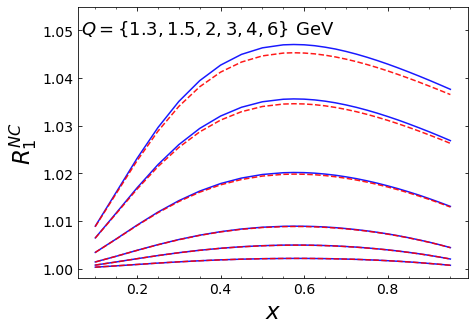

In [13]:
group= [nCTEQ15_RF1_NC_Q_1_3, nCTEQ15_RF1_NC_Q_1_5, nCTEQ15_RF1_NC_Q_2, nCTEQ15_RF1_NC_Q_3, nCTEQ15_RF1_NC_Q_4, nCTEQ15_RF1_NC_Q_6, ]
#group= [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3, nCTEQ15_RF2_NC_Q_4, nCTEQ15_RF2_NC_Q_6, ]
#group= [nCTEQ15_RF1_CCWP_Q_1_3, nCTEQ15_RF1_CCWP_Q_1_5, nCTEQ15_RF1_CCWP_Q_2, nCTEQ15_RF1_CCWP_Q_3, nCTEQ15_RF1_CCWP_Q_4, nCTEQ15_RF1_CCWP_Q_6, ]
#group= [nCTEQ15_RF2_CCWP_Q_1_3, nCTEQ15_RF2_CCWP_Q_1_5, nCTEQ15_RF2_CCWP_Q_2, nCTEQ15_RF2_CCWP_Q_3, nCTEQ15_RF2_CCWP_Q_4, nCTEQ15_RF2_CCWP_Q_6, ]

group_woG2= [nCTEQ15_RF1woG2_NC_Q_1_3, nCTEQ15_RF1woG2_NC_Q_1_5, nCTEQ15_RF1woG2_NC_Q_2, nCTEQ15_RF1woG2_NC_Q_3, nCTEQ15_RF1woG2_NC_Q_4, nCTEQ15_RF1woG2_NC_Q_6 ]
#group_woG2= [nCTEQ15_RF2woG2_NC_Q_1_3, nCTEQ15_RF2woG2_NC_Q_1_5, nCTEQ15_RF2woG2_NC_Q_2, nCTEQ15_RF2woG2_NC_Q_3, nCTEQ15_RF2woG2_NC_Q_4, nCTEQ15_RF2woG2_NC_Q_6 ]
#group_woG2= [nCTEQ15_RF1woG2_Wp_Q_1_3, nCTEQ15_RF1woG2_Wp_Q_1_5, nCTEQ15_RF1woG2_Wp_Q_2, nCTEQ15_RF1woG2_Wp_Q_3, nCTEQ15_RF1woG2_Wp_Q_4, nCTEQ15_RF1woG2_Wp_Q_6 ]
#group_woG2= [nCTEQ15_RF2woG2_Wp_Q_1_3, nCTEQ15_RF2woG2_Wp_Q_1_5, nCTEQ15_RF2woG2_Wp_Q_2, nCTEQ15_RF2woG2_Wp_Q_3, nCTEQ15_RF2woG2_Wp_Q_4, nCTEQ15_RF2woG2_Wp_Q_6 ]







Q2l = [1.3, 1.5, 2., 3., 4., 6.]

xlist= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


def model (po, a, b) :
    x= po[0]
    Q=po[1]
    par= [a, b]
    return getApproxF2TMCoF2leading(x, Q, par, 6)

xdata=[]
ydata =[]
for i, Q in zip(range(len(Q2l)), Q2l) : 
    for j, bj in zip(range(len(xlist)), xlist) :
        ydata.append(getAverage(group[i])[j])
        xdata.append([bj, Q])


   
xdata = np.array(xdata)
ydata = np.array(ydata)

def chi2 (p) : 
    a= p[0]
    b = p[1]
    theo = np.array([model(x, a, b) for x in xdata])
    ret = np.sum((ydata-theo)**2)
    #print(p, ret)
    return ret

res = minimize(chi2, [3.09, 0.0], method="Nelder-Mead")
res = minimize(chi2, res.x, method="BFGS")
p= res.x

print(res.x, res.fun, len(ydata))


#plt.figure(figsize=[7,5])
fig, ax = plt.subplots(figsize=[7,5])
for i, g in zip(range(len(group)), group) : 
    #ap = np.array([getApproxF2TMCoF2leading(x, Q2l[i], 2.11, 4) for x in xlist])
    A = list(g.keys())
    for j, a in zip(range(len(A)), A) : 
            if a== '12_6' :
                
        
                ax.plot(xlist, np.array(g[a]),alpha=0.9, linestyle="-", color="blue")
                ax.plot(xlist, np.array(group_woG2[i][a]),alpha=0.9, linestyle="dashed", color="red")
        
    #ax.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], p, 4) for x in xlist], color="blue")
    #ax.plot(xlist, np.array([getF3TMCoF3leading_UB(x, Q2l[i]) for x in xlist])/getAverage(g), color="blue", linestyle="dashed")
    #ax.plot(xlist, np.array([getF3TMCoF3leading_UB(x, Q2l[i]) for x in xlist])/getAverage(g), color="blue")
    #ax.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], [2.9, 0], 4) for x in xlist], color="red")
    #ax.plot(xlist, [1+getF2TMCoF2leading_fred(x, Q2l[i]) for x in xlist], color="blue")
    #plt.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], 2.07, 3) for x in xlist], color="blue", linestyle="dashed")
    #plt.plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[i], 2.31, 0) for x in xlist], color="green")
#fig, ax = plt.subplots(figsize=[7,5])

ax.annotate(r"$Q=\{1.3, 1.5, 2, 3, 4, 6\}$ $\mathrm{{GeV}}$", xy=(0.01, 0.9), xycoords='axes fraction', fontsize=18)


ax.set_xlabel(r"$x$", fontsize=23)
#plt.ylabel(r"$F_{2, NC}^{TMC}/F_{2, NC, leading}$", fontsize=15)
#ax.set_ylabel(r"$R_2^{NC, UB}/R_{2, ave}^{NC}$", fontsize=15)
ax.set_ylabel(r"$R_1^{NC}$", fontsize=23)
#ax.axhline(1.0, color="black")
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_major_formatter('{x:.1f}')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction="in", axis="both", which="both")
ax.set_ylim(0.998, 1.055)
#ax.set_ylim(0.99, 1.16)

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig("RF1_NC_woG2.pdf", bbox_inches="tight")

Fred plot

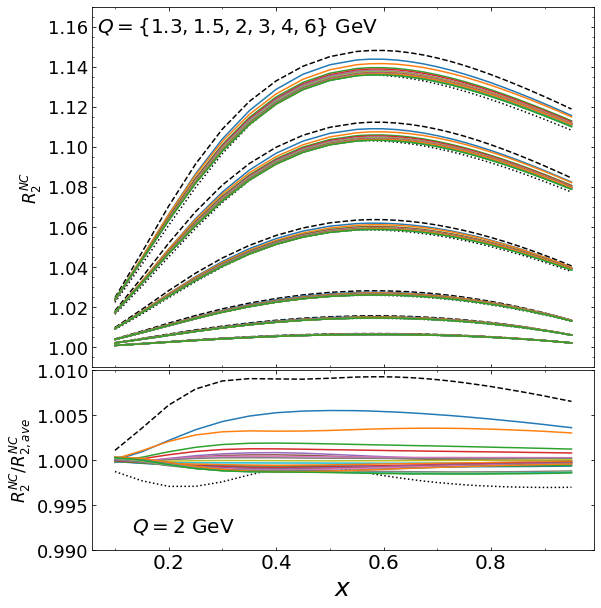

In [26]:
from matplotlib.ticker import FormatStrFormatter
def average(grou) : 
    ret = []
    for g in grou : 
        mat = []
        for key, item in g.items() : 
            if (key != '1_1' and key!='1_0') :
                #   print(key)
                mat.append(item)
        mat = np.array(mat)
        av = np.array([ np.average(mat[:, i]) for i in range(mat.shape[1]) ])
        ret.append(av)


    return ret 

fig, ax = plt.subplots(2, sharex=True, sharey=False, figsize=[9,10], gridspec_kw={'height_ratios': [2, 1]})

#group= [PROTON_RF2_NC_Q_1_3, PROTON_RF2_NC_Q_1_5, PROTON_RF2_NC_Q_2, PROTON_RF2_NC_Q_3, PROTON_RF2_NC_Q_4, PROTON_RF2_NC_Q_6 ]
#group= [PROTON_RF2_CCWP_Q_1_3, PROTON_RF2_CCWP_Q_1_5, PROTON_RF2_CCWP_Q_2, PROTON_RF2_CCWP_Q_3, PROTON_RF2_CCWP_Q_4, PROTON_RF2_CCWP_Q_6 ]
#group= [PROTON_RF2_CCWM_Q_1_3, PROTON_RF2_CCWM_Q_1_5, PROTON_RF2_CCWM_Q_2, PROTON_RF2_CCWM_Q_3, PROTON_RF2_CCWM_Q_4, PROTON_RF2_CCWM_Q_6 ]
#group= [PROTON_RF3_NC_Q_1_3, PROTON_RF3_NC_Q_1_5, PROTON_RF3_NC_Q_2, PROTON_RF3_NC_Q_3, PROTON_RF3_NC_Q_4, PROTON_RF3_NC_Q_6 ]
#group= [PROTON_RF3_CCWP_Q_1_3, PROTON_RF3_CCWP_Q_1_5, PROTON_RF3_CCWP_Q_2, PROTON_RF3_CCWP_Q_3, PROTON_RF3_CCWP_Q_4, PROTON_RF3_CCWP_Q_6 ]
#group= [PROTON_RF3_CCWM_Q_1_3, PROTON_RF3_CCWM_Q_1_5, PROTON_RF3_CCWM_Q_2, PROTON_RF3_CCWM_Q_3, PROTON_RF3_CCWM_Q_4, PROTON_RF3_CCWM_Q_6 ]


group = [nCTEQ15_RF1_NC_Q_1_3, nCTEQ15_RF1_NC_Q_1_5, nCTEQ15_RF1_NC_Q_2, nCTEQ15_RF1_NC_Q_3, nCTEQ15_RF1_NC_Q_4, nCTEQ15_RF1_NC_Q_6 ]
group= [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3,  nCTEQ15_RF2_NC_Q_4,  nCTEQ15_RF2_NC_Q_6,]
#group= [nCTEQ15_RF3_NC_Q_1_3, nCTEQ15_RF3_NC_Q_1_5, nCTEQ15_RF3_NC_Q_2, nCTEQ15_RF3_NC_Q_3, nCTEQ15_RF3_NC_Q_4, nCTEQ15_RF3_NC_Q_6 ]

#group= [nCTEQ15_RF1_CCWP_Q_1_3, nCTEQ15_RF1_CCWP_Q_1_5, nCTEQ15_RF1_CCWP_Q_2, nCTEQ15_RF1_CCWP_Q_3, nCTEQ15_RF1_CCWP_Q_4, nCTEQ15_RF1_CCWP_Q_6 ]
#group= [nCTEQ15_RF2_CCWP_Q_1_3, nCTEQ15_RF2_CCWP_Q_1_5, nCTEQ15_RF2_CCWP_Q_2, nCTEQ15_RF2_CCWP_Q_3, nCTEQ15_RF2_CCWP_Q_4, nCTEQ15_RF2_CCWP_Q_6 ]
#group = [nCTEQ15_RF3_CCWP_Q_1_3, nCTEQ15_RF3_CCWP_Q_1_5, nCTEQ15_RF3_CCWP_Q_2, nCTEQ15_RF3_CCWP_Q_3, nCTEQ15_RF3_CCWP_Q_4, nCTEQ15_RF3_CCWP_Q_6 ]

#group = [nCTEQ15_RF1_CCWM_Q_1_3, nCTEQ15_RF1_CCWM_Q_1_5, nCTEQ15_RF1_CCWM_Q_2, nCTEQ15_RF1_CCWM_Q_3, nCTEQ15_RF1_CCWM_Q_4, nCTEQ15_RF1_CCWM_Q_6 ]
#group = [nCTEQ15_RF2_CCWM_Q_1_3, nCTEQ15_RF2_CCWM_Q_1_5, nCTEQ15_RF2_CCWM_Q_2, nCTEQ15_RF2_CCWM_Q_3, nCTEQ15_RF2_CCWM_Q_4, nCTEQ15_RF2_CCWM_Q_6 ]
#group = [nCTEQ15_RF3_CCWM_Q_1_3, nCTEQ15_RF3_CCWM_Q_1_5, nCTEQ15_RF3_CCWM_Q_2, nCTEQ15_RF3_CCWM_Q_3, nCTEQ15_RF3_CCWM_Q_4, nCTEQ15_RF3_CCWM_Q_6 ]


Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]

for i, g in zip(range(len(group)), group) : 
    A=list(g.keys())
    #ap = np.array([getApproxF2TMCoF2leading(x, Q2l[i], 2.1, 4) for x in xlist])
    for j, a in zip(range(len(A)), A) : 
        if (a=='1_1') : 
            ax[0].plot(xlist, np.array(g[a]),alpha=0.99, linestyle="dashed", color="black")
        elif (a=='1_0') : 
            ax[0].plot(xlist, np.array(g[a]),alpha=0.99, linestyle="dotted", color="black")
        else : 
            ax[0].plot(xlist, np.array(g[a]),alpha=0.99, linestyle="-", color="C"+str(j-2))
            #ax[0].plot(xlist, np.array(g[a]),alpha=0.99, linestyle="-", color="C"+str(j))
        

ax[0].annotate(r"$Q=\{1.3, 1.5, 2, 3, 4, 6\}$ $\mathrm{{GeV}}$", xy=(0.01, 0.93), xycoords='axes fraction', fontsize=20)

#axs[0].set_yscale("log")
#ax[0].set_ylabel(r"$R_2^{W^+}$", fontsize=15)
ax[0].set_ylabel(r"$R_2^{NC}$", fontsize=17)
#ax[0].set_ylabel(r"$R_2^{W^-}$", fontsize=15)
#ax[0].set_ylabel(r"$R_3^{NC}$", fontsize=15)
#ax[0].set_ylabel(r"$R_3^{W^+}$", fontsize=15)
#ax[0].set_ylabel(r"$R_3^{W^-}$", fontsize=25)


ax[0].yaxis.set_minor_locator(MultipleLocator(0.005))
ax[0].set_ylim([0.99, 1.17])
#ax[0].set_ylim([0.998, 1.057])
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=10)
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(direction="in", axis="both", which="both")
ax[0].tick_params(axis='both', which='major', labelsize=18)


#####################################
ave = average(group)[0]
#ax[0].plot(xlist, ave/ave)

for i, g in zip(range(len(group)), group) : 
    A=list(g.keys())
    #ap = np.array([getApproxF2TMCoF2leading(x, Q2l[i], 2.1, 4) for x in xlist])
    if (i==0):
        for j, a in zip(range(len(A)), A) : 
            if (a=='1_1') : 
                ax[1].plot(xlist, np.array(g[a])/ave,alpha=0.99, linestyle="dashed", color="black")
            elif (a=='1_0') : 
                ax[1].plot(xlist, np.array(g[a])/ave,alpha=0.99, linestyle="dotted", color="black")
            else : 
                ax[1].plot(xlist, np.array(g[a])/ave,alpha=0.99, linestyle="-", color="C"+str(j-2), label=a)
                #ax[1].plot(xlist, np.array(g[a])/ave,alpha=0.99, linestyle="-", color="C"+str(j), label=a)

#ax[1].annotate(r"$Q=2$ $\mathrm{{GeV}}$", xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)
ax[1].annotate(r"$Q=2$ $\mathrm{{GeV}}$", xy=(0.08, 0.1), xycoords='axes fraction', fontsize=20)#

#ax.axhline(1.0, color="black")
ax[1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[1].xaxis.set_major_formatter('{x:.1f}')
ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))


ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax[1].set_xlabel(r"$x$", fontsize=25)
ax[1].tick_params(axis='y', which='major', labelsize=18)
ax[1].tick_params(axis='x', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='minor', labelsize=10)

#ax[1].set_ylabel(r"$R_2^{W^+}/R_{2, ave}^{W^+}$", fontsize=15)
ax[1].set_ylabel(r"$R_2^{NC}/R_{2, ave}^{NC}$", fontsize=17)
#ax[1].set_ylabel(r"$R_2^{W^-}/R_{2, ave}^{W^-}$", fontsize=15)
#ax[1].set_ylabel(r"$R_3^{NC}/R_{3, ave}^{NC}$", fontsize=15)
#ax[1].set_ylabel(r"$R_3^{W^+}/R_{3, ave}^{W^+}$", fontsize=15)
#ax[1].set_ylabel(r"$R_3^{W^-}/R_{3, ave}^{W^-}$", fontsize=25)
#ax[1].legend()
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[1].tick_params(direction="in", axis="both", which="both")
ax[1].set_ylim(0.99, 1.01)

plt.subplots_adjust(hspace=0.01, wspace = 0.00)

plt.savefig("nCTEQ15_F2NC.pdf", bbox_inches="tight")




In [4]:
def getAverage(dt) : 
    arr=[]
    for k, i in dt.items(): 
        if k!='1_1' and k!='1_0'   : 
            #print(k)
            arr.append(i)

    arr= np.array(arr)
    vec= []
    Ncol= arr.shape[1]
    for i in range(Ncol) : 
        vec.append(np.average(arr[:,i]))
    return np.array(vec)


def getFittedParams(init, gr, xlist, Q2l,  mode=2, order=6) : 

    def model (po, a, b) :
        x= po[0]
        Q=po[1]
        par= [a, b]
        if (mode==0) : 
            return getApproxF1TMCoF1leading(x, Q, par, order)
        elif mode==1 : 
            return getApproxF2TMCoF2leading(x, Q, par, order)
        elif mode==2 : 
            return getApproxF3TMCoF3leading(x, Q, par, order)
        else : 
            print("unknwon mode!")
            exit(1)

    xdata=[]
    ydata =[]
    for i, Q in zip(range(len(Q2l)), Q2l) : 
        for j, bj in zip(range(len(xlist)), xlist) :
            for g in gr : 
                ydata.append(getAverage(g[i])[j])
                xdata.append([bj, Q]) 
    xdata = np.array(xdata)
    ydata = np.array(ydata)

    def chi2 (p) : 
        a= p[0]
        b = p[1]
        theo = np.array([model(x, a, b) for x in xdata])
        ret = np.sum((ydata-theo)**2)
        #print(p, ret)
        return ret

    res = minimize(chi2, [2.17, 0.0], method="Nelder-Mead")
    res = minimize(chi2, res.x, method="BFGS")
    p= res.x

    print(mode, res.x, res.fun, len(ydata))
    return p
        

0 [ 2.35218125 -0.1223749 ] 0.00011706831114971274 468
1 [ 2.2641975  -0.07417693] 0.0006505592990632508 468
2 [2.08975421 0.03468091] 6.834753800453068e-05 468


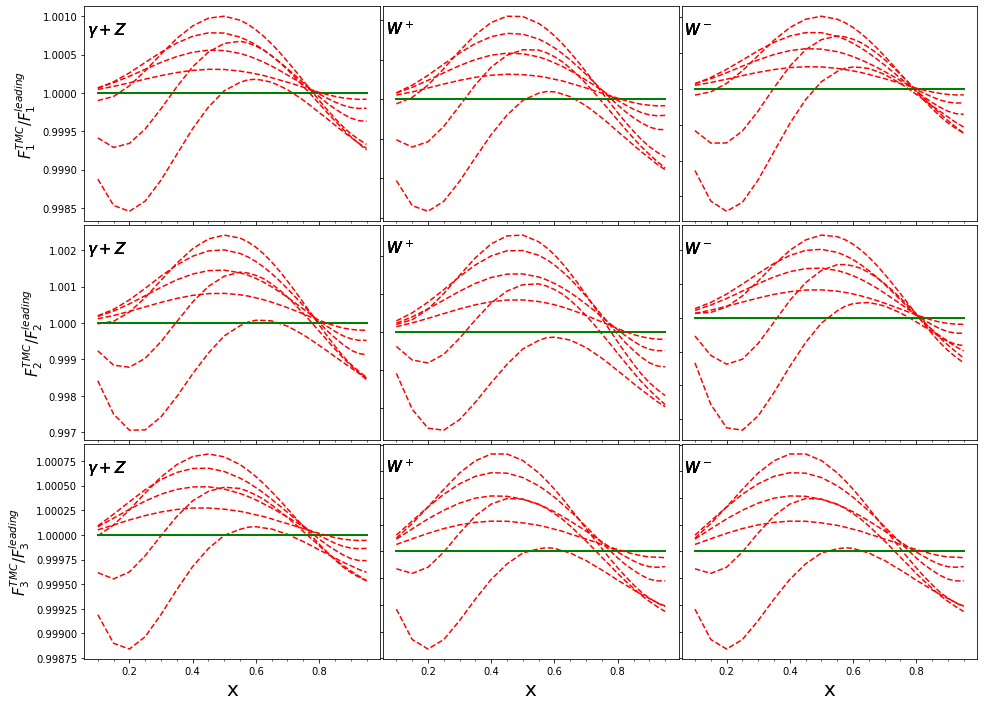

In [8]:
F1_NC = [nCTEQ15_RF1_NC_Q_1_3, nCTEQ15_RF1_NC_Q_1_5, nCTEQ15_RF1_NC_Q_2, nCTEQ15_RF1_NC_Q_3, nCTEQ15_RF1_NC_Q_4, nCTEQ15_RF1_NC_Q_6 ]
F2_NC = [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3,  nCTEQ15_RF2_NC_Q_4,  nCTEQ15_RF2_NC_Q_6,]
F3_NC = [nCTEQ15_RF3_NC_Q_1_3, nCTEQ15_RF3_NC_Q_1_5, nCTEQ15_RF3_NC_Q_2, nCTEQ15_RF3_NC_Q_3, nCTEQ15_RF3_NC_Q_4, nCTEQ15_RF3_NC_Q_6 ]

F1_CCWP = [nCTEQ15_RF1_CCWP_Q_1_3, nCTEQ15_RF1_CCWP_Q_1_5, nCTEQ15_RF1_CCWP_Q_2, nCTEQ15_RF1_CCWP_Q_3, nCTEQ15_RF1_CCWP_Q_4, nCTEQ15_RF1_CCWP_Q_6 ]
F2_CCWP = [nCTEQ15_RF2_CCWP_Q_1_3, nCTEQ15_RF2_CCWP_Q_1_5, nCTEQ15_RF2_CCWP_Q_2, nCTEQ15_RF2_CCWP_Q_3, nCTEQ15_RF2_CCWP_Q_4, nCTEQ15_RF2_CCWP_Q_6 ]
F3_CCWP = [nCTEQ15_RF3_CCWP_Q_1_3, nCTEQ15_RF3_CCWP_Q_1_5, nCTEQ15_RF3_CCWP_Q_2, nCTEQ15_RF3_CCWP_Q_3, nCTEQ15_RF3_CCWP_Q_4, nCTEQ15_RF3_CCWP_Q_6 ]

F1_CCWM = [nCTEQ15_RF1_CCWM_Q_1_3, nCTEQ15_RF1_CCWM_Q_1_5, nCTEQ15_RF1_CCWM_Q_2, nCTEQ15_RF1_CCWM_Q_3, nCTEQ15_RF1_CCWM_Q_4, nCTEQ15_RF1_CCWM_Q_6 ]
F2_CCWM = [nCTEQ15_RF2_CCWM_Q_1_3, nCTEQ15_RF2_CCWM_Q_1_5, nCTEQ15_RF2_CCWM_Q_2, nCTEQ15_RF2_CCWM_Q_3, nCTEQ15_RF2_CCWM_Q_4, nCTEQ15_RF2_CCWM_Q_6 ]
F3_CCWM = [nCTEQ15_RF3_CCWM_Q_1_3, nCTEQ15_RF3_CCWM_Q_1_5, nCTEQ15_RF3_CCWM_Q_2, nCTEQ15_RF3_CCWM_Q_3, nCTEQ15_RF3_CCWM_Q_4, nCTEQ15_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.07, 2.06, 2.07], [2.09, 2.08, 2.09], [2.17, 2.17, 2.18]]
gamma_fit= []
#gamma= [[2.11, 2.11, 2.11], [2.11, 2.11, 2.11], [2.11, 2.11, 2.11]]
curr = ["$\gamma+ Z$", "$W^+$", "$W^-$"]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]

order=4
fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    group = dt[i]
    par = getFittedParams([gamma[i][0], 0], group, xlist, Q2l, i, order)
    for j in range(3) :   
        group = dt[i][j]      
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g))/getAverage(g),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, np.array([getApproxF1TMCoF1leading(x, Q2l[ind], par, 
order) for x in xlist])/getAverage(g), color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, np.array([getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist])/getAverage(g), color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, np.array([getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist])/getAverage(g), color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("nCTEQ15_approx.pdf", bbox_inches="tight")

0 [ 2.35218125 -0.1223749 ] 0.00011706831114971274 468
1 [ 2.2641975  -0.07417693] 0.0006505592990632508 468
2 [2.08975421 0.03468091] 6.834753800453068e-05 468


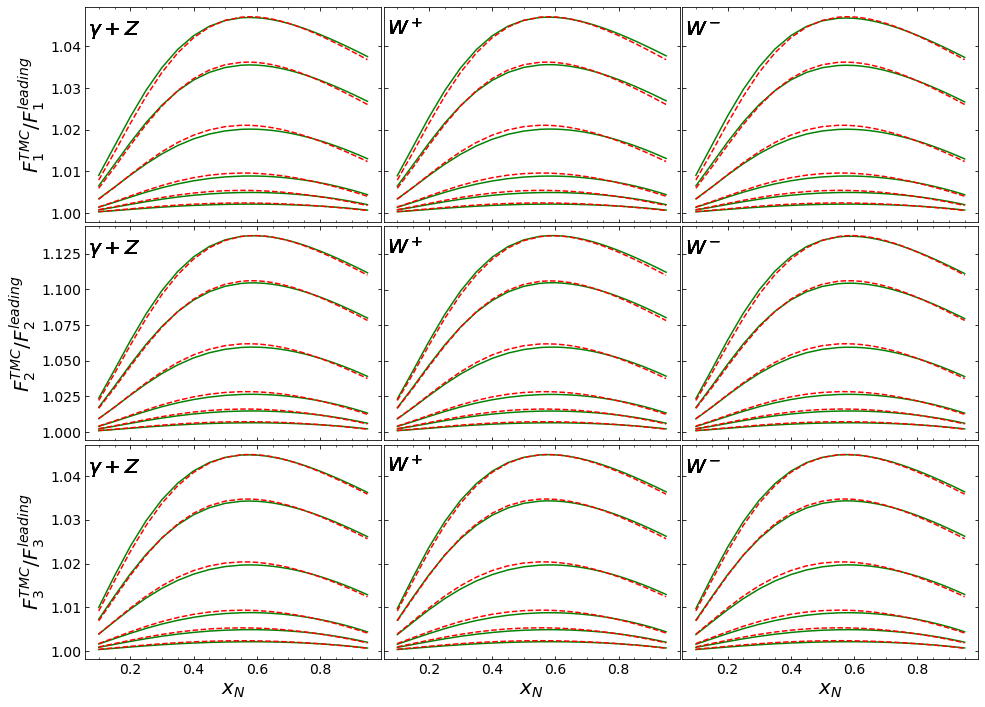

In [10]:
F1_NC = [nCTEQ15_RF1_NC_Q_1_3, nCTEQ15_RF1_NC_Q_1_5, nCTEQ15_RF1_NC_Q_2, nCTEQ15_RF1_NC_Q_3, nCTEQ15_RF1_NC_Q_4, nCTEQ15_RF1_NC_Q_6 ]
F2_NC = [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3,  nCTEQ15_RF2_NC_Q_4,  nCTEQ15_RF2_NC_Q_6,]
F3_NC = [nCTEQ15_RF3_NC_Q_1_3, nCTEQ15_RF3_NC_Q_1_5, nCTEQ15_RF3_NC_Q_2, nCTEQ15_RF3_NC_Q_3, nCTEQ15_RF3_NC_Q_4, nCTEQ15_RF3_NC_Q_6 ]

F1_CCWP = [nCTEQ15_RF1_CCWP_Q_1_3, nCTEQ15_RF1_CCWP_Q_1_5, nCTEQ15_RF1_CCWP_Q_2, nCTEQ15_RF1_CCWP_Q_3, nCTEQ15_RF1_CCWP_Q_4, nCTEQ15_RF1_CCWP_Q_6 ]
F2_CCWP = [nCTEQ15_RF2_CCWP_Q_1_3, nCTEQ15_RF2_CCWP_Q_1_5, nCTEQ15_RF2_CCWP_Q_2, nCTEQ15_RF2_CCWP_Q_3, nCTEQ15_RF2_CCWP_Q_4, nCTEQ15_RF2_CCWP_Q_6 ]
F3_CCWP = [nCTEQ15_RF3_CCWP_Q_1_3, nCTEQ15_RF3_CCWP_Q_1_5, nCTEQ15_RF3_CCWP_Q_2, nCTEQ15_RF3_CCWP_Q_3, nCTEQ15_RF3_CCWP_Q_4, nCTEQ15_RF3_CCWP_Q_6 ]

F1_CCWM = [nCTEQ15_RF1_CCWM_Q_1_3, nCTEQ15_RF1_CCWM_Q_1_5, nCTEQ15_RF1_CCWM_Q_2, nCTEQ15_RF1_CCWM_Q_3, nCTEQ15_RF1_CCWM_Q_4, nCTEQ15_RF1_CCWM_Q_6 ]
F2_CCWM = [nCTEQ15_RF2_CCWM_Q_1_3, nCTEQ15_RF2_CCWM_Q_1_5, nCTEQ15_RF2_CCWM_Q_2, nCTEQ15_RF2_CCWM_Q_3, nCTEQ15_RF2_CCWM_Q_4, nCTEQ15_RF2_CCWM_Q_6 ]
F3_CCWM = [nCTEQ15_RF3_CCWM_Q_1_3, nCTEQ15_RF3_CCWM_Q_1_5, nCTEQ15_RF3_CCWM_Q_2, nCTEQ15_RF3_CCWM_Q_3, nCTEQ15_RF3_CCWM_Q_4, nCTEQ15_RF3_CCWM_Q_6 ]


dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.05, 2.05, 2.05], [2.05, 2.05, 2.05], [2.15, 2.15, 2.15]]
gam=2.09
#gamma= [[gam, gam, gam], [gam, gam, gam], [gam, gam, gam]]
order=4
curr = ["$\gamma+ Z$", "$W^+$", "$W^-$"]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    group = dt[i]
    par = getFittedParams([gamma[i][0], 0], group, xlist, Q2l, i, order)
    for j in range(3) :    
        group = dt[i][j]     
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=20)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=20)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=20)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel(r"$x_N$", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=20)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[i, j].tick_params(axis='both', which='major', labelsize=14)
            ax[i, j].tick_params(axis='both', which='minor', labelsize=10)
            ax[i,j].tick_params(direction="in", axis="both", which="both")
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')


plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("nCTEQ15_approx.pdf", bbox_inches="tight")

0 [ 2.35287521 -0.12276387] 3.782851022682433e-05 156
0 [ 2.3381213  -0.11721062] 3.8704973399495306e-05 156
0 [ 2.36549132 -0.12712582] 3.893664551094095e-05 156
1 [ 2.26579074 -0.07499362] 0.00020962156666918868 156
1 [ 2.25038361 -0.0690844 ] 0.00021709360756304232 156
1 [ 2.27636669 -0.07843131] 0.00021037857164703873 156
2 [2.09782549 0.03144918] 2.160163970887865e-05 156
2 [2.08580501 0.03625719] 2.3022173187593797e-05 156
2 [2.08580501 0.03625719] 2.3022173187593797e-05 156


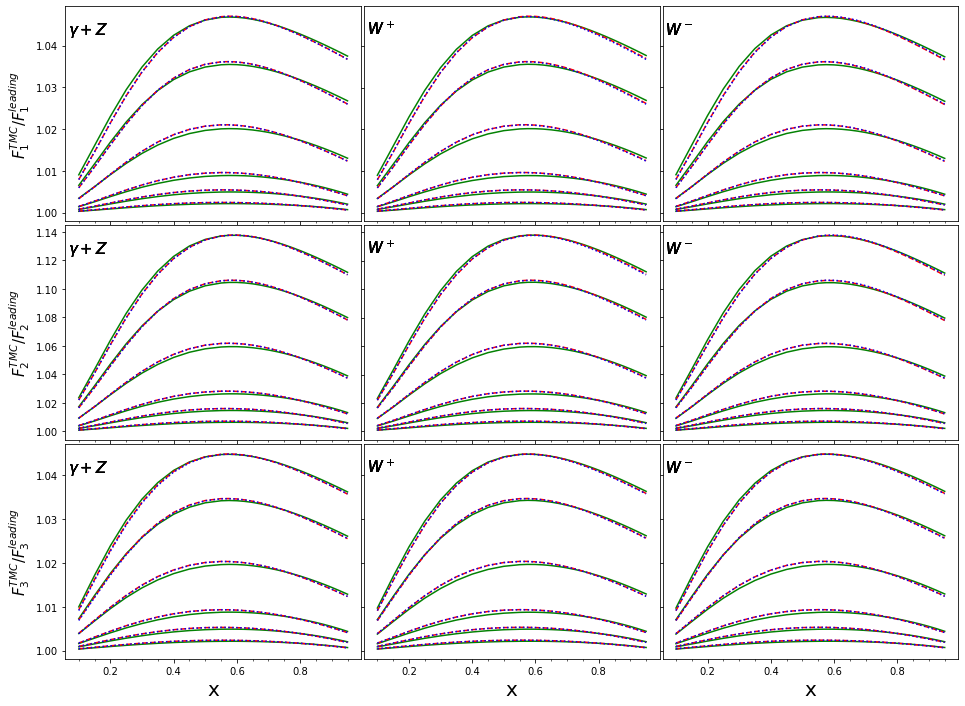

In [14]:
F1_NC = [nCTEQ15_RF1_NC_Q_1_3, nCTEQ15_RF1_NC_Q_1_5, nCTEQ15_RF1_NC_Q_2, nCTEQ15_RF1_NC_Q_3, nCTEQ15_RF1_NC_Q_4, nCTEQ15_RF1_NC_Q_6 ]
F2_NC = [nCTEQ15_RF2_NC_Q_1_3, nCTEQ15_RF2_NC_Q_1_5, nCTEQ15_RF2_NC_Q_2, nCTEQ15_RF2_NC_Q_3,  nCTEQ15_RF2_NC_Q_4,  nCTEQ15_RF2_NC_Q_6,]
F3_NC = [nCTEQ15_RF3_NC_Q_1_3, nCTEQ15_RF3_NC_Q_1_5, nCTEQ15_RF3_NC_Q_2, nCTEQ15_RF3_NC_Q_3, nCTEQ15_RF3_NC_Q_4, nCTEQ15_RF3_NC_Q_6 ]

F1_CCWP = [nCTEQ15_RF1_CCWP_Q_1_3, nCTEQ15_RF1_CCWP_Q_1_5, nCTEQ15_RF1_CCWP_Q_2, nCTEQ15_RF1_CCWP_Q_3, nCTEQ15_RF1_CCWP_Q_4, nCTEQ15_RF1_CCWP_Q_6 ]
F2_CCWP = [nCTEQ15_RF2_CCWP_Q_1_3, nCTEQ15_RF2_CCWP_Q_1_5, nCTEQ15_RF2_CCWP_Q_2, nCTEQ15_RF2_CCWP_Q_3, nCTEQ15_RF2_CCWP_Q_4, nCTEQ15_RF2_CCWP_Q_6 ]
F3_CCWP = [nCTEQ15_RF3_CCWP_Q_1_3, nCTEQ15_RF3_CCWP_Q_1_5, nCTEQ15_RF3_CCWP_Q_2, nCTEQ15_RF3_CCWP_Q_3, nCTEQ15_RF3_CCWP_Q_4, nCTEQ15_RF3_CCWP_Q_6 ]

F1_CCWM = [nCTEQ15_RF1_CCWM_Q_1_3, nCTEQ15_RF1_CCWM_Q_1_5, nCTEQ15_RF1_CCWM_Q_2, nCTEQ15_RF1_CCWM_Q_3, nCTEQ15_RF1_CCWM_Q_4, nCTEQ15_RF1_CCWM_Q_6 ]
F2_CCWM = [nCTEQ15_RF2_CCWM_Q_1_3, nCTEQ15_RF2_CCWM_Q_1_5, nCTEQ15_RF2_CCWM_Q_2, nCTEQ15_RF2_CCWM_Q_3, nCTEQ15_RF2_CCWM_Q_4, nCTEQ15_RF2_CCWM_Q_6 ]
F3_CCWM = [nCTEQ15_RF3_CCWM_Q_1_3, nCTEQ15_RF3_CCWM_Q_1_5, nCTEQ15_RF3_CCWM_Q_2, nCTEQ15_RF3_CCWM_Q_3, nCTEQ15_RF3_CCWM_Q_4, nCTEQ15_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.07, 2.06, 2.07], [2.09, 2.08, 2.09], [2.17, 2.17, 2.18]]
gamma_comb = [[ 2.352 , -0.122 ],  [ 2.264 , -0.074],  [2.090 , 0.035] ]

gamma_fit= []
#gamma= [[2.11, 2.11, 2.11], [2.11, 2.11, 2.11], [2.11, 2.11, 2.11]]
curr = ["$\gamma+ Z$", "$W^+$", "$W^-$"]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]

order=4
fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    for j in range(3) : 
        group = dt[i][j]
        par = getFittedParams([gamma[i][0], 0], [group], xlist, Q2l, i, order)
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, order) for x in xlist], color="red",  linestyle="dashed")  
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("nCTEQ15_approx.pdf", bbox_inches="tight")

In [ ]:
A[0]!="1_1"

False

0 [ 2.22197405 -0.0799316 ] 0.00020240523458068968 468
1 [ 2.13532924 -0.03218561] 0.00122388459637314 468
2 [2.00719835 0.05875058] 0.00016978571801806275 468


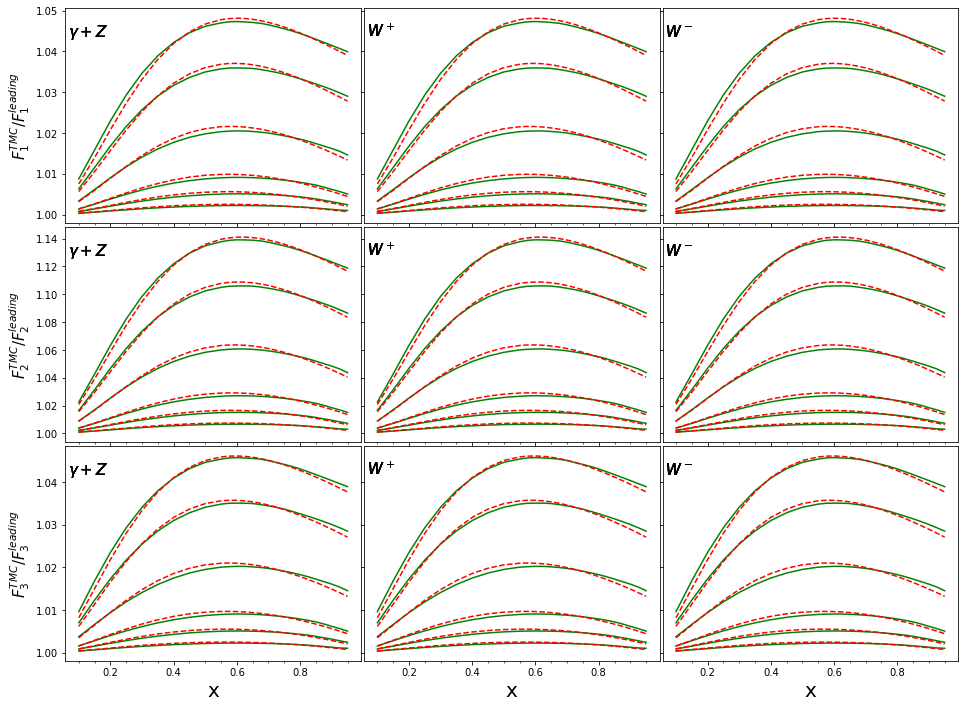

In [17]:


F1_NC = [EPPS16_RF1_NC_Q_1_3, EPPS16_RF1_NC_Q_1_5, EPPS16_RF1_NC_Q_2, EPPS16_RF1_NC_Q_3, EPPS16_RF1_NC_Q_4, EPPS16_RF1_NC_Q_6 ]
F2_NC = [EPPS16_RF2_NC_Q_1_3, EPPS16_RF2_NC_Q_1_5, EPPS16_RF2_NC_Q_2, EPPS16_RF2_NC_Q_3,  EPPS16_RF2_NC_Q_4,  EPPS16_RF2_NC_Q_6,]
F3_NC = [EPPS16_RF3_NC_Q_1_3, EPPS16_RF3_NC_Q_1_5, EPPS16_RF3_NC_Q_2, EPPS16_RF3_NC_Q_3, EPPS16_RF3_NC_Q_4, EPPS16_RF3_NC_Q_6 ]

F1_CCWP = [EPPS16_RF1_CCWP_Q_1_3, EPPS16_RF1_CCWP_Q_1_5, EPPS16_RF1_CCWP_Q_2, EPPS16_RF1_CCWP_Q_3, EPPS16_RF1_CCWP_Q_4, EPPS16_RF1_CCWP_Q_6 ]
F2_CCWP = [EPPS16_RF2_CCWP_Q_1_3, EPPS16_RF2_CCWP_Q_1_5, EPPS16_RF2_CCWP_Q_2, EPPS16_RF2_CCWP_Q_3, EPPS16_RF2_CCWP_Q_4, EPPS16_RF2_CCWP_Q_6 ]
F3_CCWP = [EPPS16_RF3_CCWP_Q_1_3, EPPS16_RF3_CCWP_Q_1_5, EPPS16_RF3_CCWP_Q_2, EPPS16_RF3_CCWP_Q_3, EPPS16_RF3_CCWP_Q_4, EPPS16_RF3_CCWP_Q_6 ]

F1_CCWM = [EPPS16_RF1_CCWM_Q_1_3, EPPS16_RF1_CCWM_Q_1_5, EPPS16_RF1_CCWM_Q_2, EPPS16_RF1_CCWM_Q_3, EPPS16_RF1_CCWM_Q_4, EPPS16_RF1_CCWM_Q_6 ]
F2_CCWM = [EPPS16_RF2_CCWM_Q_1_3, EPPS16_RF2_CCWM_Q_1_5, EPPS16_RF2_CCWM_Q_2, EPPS16_RF2_CCWM_Q_3, EPPS16_RF2_CCWM_Q_4, EPPS16_RF2_CCWM_Q_6 ]
F3_CCWM = [EPPS16_RF3_CCWM_Q_1_3, EPPS16_RF3_CCWM_Q_1_5, EPPS16_RF3_CCWM_Q_2, EPPS16_RF3_CCWM_Q_3, EPPS16_RF3_CCWM_Q_4, EPPS16_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.05, 2.05, 2.05], [2.05, 2.05, 2.05], [2.15, 2.15, 2.15]]
gam=2.09
#gamma= [[gam, gam, gam], [gam, gam, gam], [gam, gam, gam]]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    group = dt[i]
    par = getFittedParams([gamma[i][0], 0], group, xlist, Q2l, i, order)
    group = dt[i][j]
    for j in range(3) :         
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("EPPS16.pdf", bbox_inches="tight")

0 [ 2.44067728 -0.15630611] 8.053500418509128e-05 468
1 [ 2.3548702 -0.1097523] 0.00047564490515089835 468
2 [2.12317839 0.02398372] 5.991389413531678e-05 468


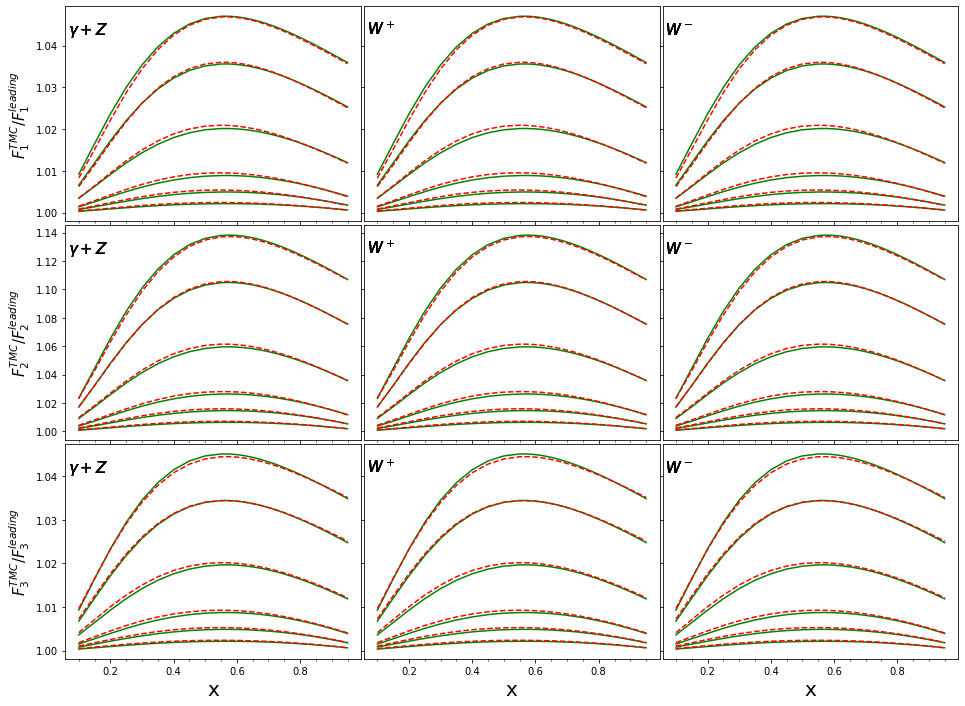

In [18]:
F1_NC = [TUJU19_RF1_NC_Q_1_3, TUJU19_RF1_NC_Q_1_5, TUJU19_RF1_NC_Q_2, TUJU19_RF1_NC_Q_3, TUJU19_RF1_NC_Q_4, TUJU19_RF1_NC_Q_6 ]
F2_NC = [TUJU19_RF2_NC_Q_1_3, TUJU19_RF2_NC_Q_1_5, TUJU19_RF2_NC_Q_2, TUJU19_RF2_NC_Q_3,  TUJU19_RF2_NC_Q_4,  TUJU19_RF2_NC_Q_6,]
F3_NC = [TUJU19_RF3_NC_Q_1_3, TUJU19_RF3_NC_Q_1_5, TUJU19_RF3_NC_Q_2, TUJU19_RF3_NC_Q_3, TUJU19_RF3_NC_Q_4, TUJU19_RF3_NC_Q_6 ]

F1_CCWP = [TUJU19_RF1_CCWP_Q_1_3, TUJU19_RF1_CCWP_Q_1_5, TUJU19_RF1_CCWP_Q_2, TUJU19_RF1_CCWP_Q_3, TUJU19_RF1_CCWP_Q_4, TUJU19_RF1_CCWP_Q_6 ]
F2_CCWP = [TUJU19_RF2_CCWP_Q_1_3, TUJU19_RF2_CCWP_Q_1_5, TUJU19_RF2_CCWP_Q_2, TUJU19_RF2_CCWP_Q_3, TUJU19_RF2_CCWP_Q_4, TUJU19_RF2_CCWP_Q_6 ]
F3_CCWP = [TUJU19_RF3_CCWP_Q_1_3, TUJU19_RF3_CCWP_Q_1_5, TUJU19_RF3_CCWP_Q_2, TUJU19_RF3_CCWP_Q_3, TUJU19_RF3_CCWP_Q_4, TUJU19_RF3_CCWP_Q_6 ]

F1_CCWM = [TUJU19_RF1_CCWM_Q_1_3, TUJU19_RF1_CCWM_Q_1_5, TUJU19_RF1_CCWM_Q_2, TUJU19_RF1_CCWM_Q_3, TUJU19_RF1_CCWM_Q_4, TUJU19_RF1_CCWM_Q_6 ]
F2_CCWM = [TUJU19_RF2_CCWM_Q_1_3, TUJU19_RF2_CCWM_Q_1_5, TUJU19_RF2_CCWM_Q_2, TUJU19_RF2_CCWM_Q_3, TUJU19_RF2_CCWM_Q_4, TUJU19_RF2_CCWM_Q_6 ]
F3_CCWM = [TUJU19_RF3_CCWM_Q_1_3, TUJU19_RF3_CCWM_Q_1_5, TUJU19_RF3_CCWM_Q_2, TUJU19_RF3_CCWM_Q_3, TUJU19_RF3_CCWM_Q_4, TUJU19_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.02, 2.02, 2.02], [2.04, 2.04, 2.04], [2.18, 2.18, 2.18]]
order=4
gam=2.1
#gamma= [[gam, gam, gam], [gam, gam, gam], [gam, gam, gam]]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    group = dt[i]
    par = getFittedParams([gamma[i][0], 0], group, xlist, Q2l, i, order)
    group = dt[i][j]
    for j in range(3) :         
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("TUJU19.pdf", bbox_inches="tight")

0 [ 2.24040015 -0.09501611] 0.0001597794568717223 468
1 [ 2.15162239 -0.04615466] 0.0008867432572898567 468
2 [2.09416744 0.04061151] 9.874860575387201e-05 468


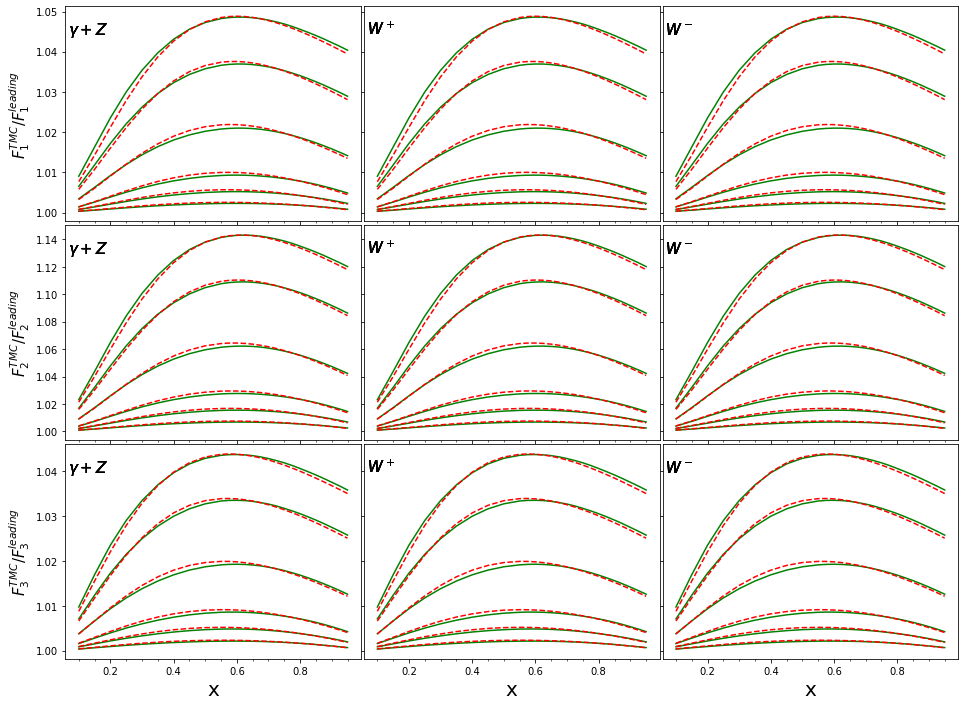

In [19]:
F1_NC = [nNN_RF1_NC_Q_1_3, nNN_RF1_NC_Q_1_5, nNN_RF1_NC_Q_2, nNN_RF1_NC_Q_3, nNN_RF1_NC_Q_4, nNN_RF1_NC_Q_6 ]
F2_NC = [nNN_RF2_NC_Q_1_3, nNN_RF2_NC_Q_1_5, nNN_RF2_NC_Q_2, nNN_RF2_NC_Q_3,  nNN_RF2_NC_Q_4,  nNN_RF2_NC_Q_6,]
F3_NC = [nNN_RF3_NC_Q_1_3, nNN_RF3_NC_Q_1_5, nNN_RF3_NC_Q_2, nNN_RF3_NC_Q_3, nNN_RF3_NC_Q_4, nNN_RF3_NC_Q_6 ]

F1_CCWP = [nNN_RF1_CCWP_Q_1_3, nNN_RF1_CCWP_Q_1_5, nNN_RF1_CCWP_Q_2, nNN_RF1_CCWP_Q_3, nNN_RF1_CCWP_Q_4, nNN_RF1_CCWP_Q_6 ]
F2_CCWP = [nNN_RF2_CCWP_Q_1_3, nNN_RF2_CCWP_Q_1_5, nNN_RF2_CCWP_Q_2, nNN_RF2_CCWP_Q_3, nNN_RF2_CCWP_Q_4, nNN_RF2_CCWP_Q_6 ]
F3_CCWP = [nNN_RF3_CCWP_Q_1_3, nNN_RF3_CCWP_Q_1_5, nNN_RF3_CCWP_Q_2, nNN_RF3_CCWP_Q_3, nNN_RF3_CCWP_Q_4, nNN_RF3_CCWP_Q_6 ]

F1_CCWM = [nNN_RF1_CCWM_Q_1_3, nNN_RF1_CCWM_Q_1_5, nNN_RF1_CCWM_Q_2, nNN_RF1_CCWM_Q_3, nNN_RF1_CCWM_Q_4, nNN_RF1_CCWM_Q_6 ]
F2_CCWM = [nNN_RF2_CCWM_Q_1_3, nNN_RF2_CCWM_Q_1_5, nNN_RF2_CCWM_Q_2, nNN_RF2_CCWM_Q_3, nNN_RF2_CCWM_Q_4, nNN_RF2_CCWM_Q_6 ]
F3_CCWM = [nNN_RF3_CCWM_Q_1_3, nNN_RF3_CCWM_Q_1_5, nNN_RF3_CCWM_Q_2, nNN_RF3_CCWM_Q_3, nNN_RF3_CCWM_Q_4, nNN_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.02, 2.02, 2.02], [2.04, 2.04, 2.04], [2.18, 2.18, 2.18]]

order=4
gam=2.1
#gamma= [[gam, gam, gam], [gam, gam, gam], [gam, gam, gam]]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    group = dt[i]
    par = getFittedParams([gamma[i][0], 0], group, xlist, Q2l, i, order)
    group = dt[i][j]
    for j in range(3) :         
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :    
                if (a!='1_1' and a!='1_0')  :
                    #print(a)
                    pass#ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey")


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("nNNPDF2.pdf", bbox_inches="tight")

0 [ 2.55709993 -0.2201987 ] 3.457503765363737e-05 156
0 [ 2.41984832 -0.06422683] 4.973766623005234e-05 156
0 [ 2.60154089 -0.24504211] 3.442128695413639e-05 156
1 [ 2.4608925 -0.1681749] 0.000205891011195381 156
1 [ 2.34656052 -0.02504155] 0.0002990019759528354 156
1 [ 2.50137912 -0.19103454] 0.00021060045197214674 156
2 [ 2.17017063e+00 -5.27982831e-04] 2.207528284893093e-05 156
2 [2.24759991 0.02662378] 2.0847427800879894e-05 156
2 [2.24759991 0.02662378] 2.0847427800879894e-05 156


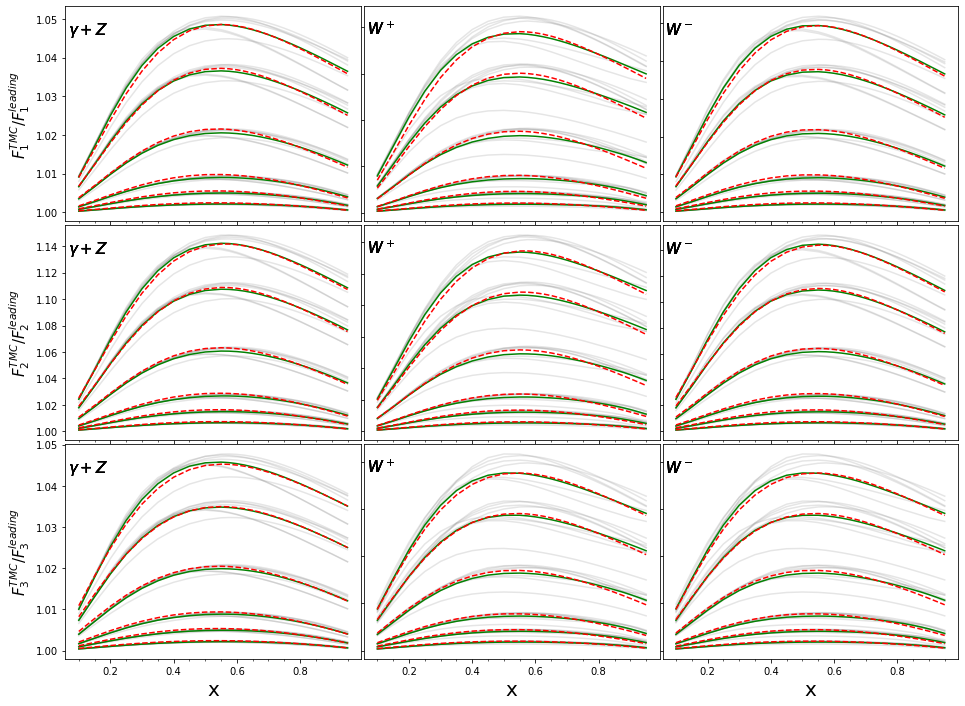

In [5]:

F1_NC = [PROTON_RF1_NC_Q_1_3, PROTON_RF1_NC_Q_1_5, PROTON_RF1_NC_Q_2, PROTON_RF1_NC_Q_3, PROTON_RF1_NC_Q_4, PROTON_RF1_NC_Q_6 ]
F2_NC = [PROTON_RF2_NC_Q_1_3, PROTON_RF2_NC_Q_1_5, PROTON_RF2_NC_Q_2, PROTON_RF2_NC_Q_3,  PROTON_RF2_NC_Q_4,  PROTON_RF2_NC_Q_6,]
F3_NC = [PROTON_RF3_NC_Q_1_3, PROTON_RF3_NC_Q_1_5, PROTON_RF3_NC_Q_2, PROTON_RF3_NC_Q_3, PROTON_RF3_NC_Q_4, PROTON_RF3_NC_Q_6 ]

F1_CCWP = [PROTON_RF1_CCWP_Q_1_3, PROTON_RF1_CCWP_Q_1_5, PROTON_RF1_CCWP_Q_2, PROTON_RF1_CCWP_Q_3, PROTON_RF1_CCWP_Q_4, PROTON_RF1_CCWP_Q_6 ]
F2_CCWP = [PROTON_RF2_CCWP_Q_1_3, PROTON_RF2_CCWP_Q_1_5, PROTON_RF2_CCWP_Q_2, PROTON_RF2_CCWP_Q_3, PROTON_RF2_CCWP_Q_4, PROTON_RF2_CCWP_Q_6 ]
F3_CCWP = [PROTON_RF3_CCWP_Q_1_3, PROTON_RF3_CCWP_Q_1_5, PROTON_RF3_CCWP_Q_2, PROTON_RF3_CCWP_Q_3, PROTON_RF3_CCWP_Q_4, PROTON_RF3_CCWP_Q_6 ]

F1_CCWM = [PROTON_RF1_CCWM_Q_1_3, PROTON_RF1_CCWM_Q_1_5, PROTON_RF1_CCWM_Q_2, PROTON_RF1_CCWM_Q_3, PROTON_RF1_CCWM_Q_4, PROTON_RF1_CCWM_Q_6 ]
F2_CCWM = [PROTON_RF2_CCWM_Q_1_3, PROTON_RF2_CCWM_Q_1_5, PROTON_RF2_CCWM_Q_2, PROTON_RF2_CCWM_Q_3, PROTON_RF2_CCWM_Q_4, PROTON_RF2_CCWM_Q_6 ]
F3_CCWM = [PROTON_RF3_CCWM_Q_1_3, PROTON_RF3_CCWM_Q_1_5, PROTON_RF3_CCWM_Q_2, PROTON_RF3_CCWM_Q_3, PROTON_RF3_CCWM_Q_4, PROTON_RF3_CCWM_Q_6 ]

dt = [[F1_NC, F1_CCWP, F1_CCWM], [F2_NC, F2_CCWP, F2_CCWM], [F3_NC, F3_CCWP, F3_CCWP]]
gamma= [[2.07, 2.06, 2.07], [2.09, 2.08, 2.09], [2.17, 2.17, 2.18]]
gamma_comb = [[ 2.352 , -0.122 ],  [ 2.264 , -0.074],  [2.090 , 0.035] ]

gamma_fit= []
#gamma= [[2.11, 2.11, 2.11], [2.11, 2.11, 2.11], [2.11, 2.11, 2.11]]
curr = ["$\gamma+ Z$", "$W^+$", "$W^-$"]

Q2l = [1.3, 1.5, 2., 3., 4., 6.]
xlist = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.575, 0.60, 0.625, 
                0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]

order=4
fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=[16, 12], )
for i in range(3) : 
    for j in range(3) : 
        group = dt[i][j]
        par = getFittedParams([gamma[i][0], 0], [group], xlist, Q2l, i, order)
        for ind, g in zip(range(len(group)), group) : 
            A=list(g.keys())
            for k, a in zip(range(len(A)), A) :   
                if (ind==0) : 
                    pass
                ax[i, j].plot(xlist, np.array(g[a]),alpha=0.2, linestyle="-", color="grey", label = a)


            ax[i, j].plot(xlist, np.array(getAverage(g)),alpha=0.99, linestyle="-", color="green")

            ax[i, j].annotate(curr[j], xy=(0.01, 0.87), xycoords='axes fraction', fontsize=15)

            if i==0 :              
                ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], par, order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF1TMCoF1leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{1}^{TMC}/F_{1}^{leading}$", fontsize=15)

            elif i==1 : 
                ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                #ax[i, j].plot(xlist, [getApproxF2TMCoF2leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{2}^{TMC}/F_{2}^{leading}$", fontsize=15)
            elif i==2 : 
                ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], par, 
order) for x in xlist], color="red",  linestyle="dashed")  
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind], gamma_comb[i], order) for x in xlist], color="blue", linestyle="dotted")
                #ax[i, j].plot(xlist, [getApproxF3TMCoF3leading(x, Q2l[ind],  [gamma[i][j], 0], 6) for x in xlist], color="red")
                ax[i, j].set_xlabel("x", fontsize=20)
                if j==0 : 
                    ax[i, j].set_ylabel(r"$F_{3}^{TMC}/F_{3}^{leading}$", fontsize=15)
            else : 
                print("Unknown!")
                exit(1)

            if (j!=0) : 
                ax[i, j].yaxis.set_ticklabels([]) 

                
            

        
            ax[i, j].xaxis.set_major_locator(MultipleLocator(0.2))
            ax[i, j].xaxis.set_major_formatter('{x:.1f}')
            ax[i, j].xaxis.set_minor_locator(MultipleLocator(0.05))
            #ax[i, j].legend()
plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("PROTON_approx.pdf", bbox_inches="tight")